In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue19cs312-assignment/sample_submission.csv
/kaggle/input/ue19cs312-assignment/submission.csv
/kaggle/input/ue19cs312-assignment/train.csv
/kaggle/input/ue19cs312-assignment/test.csv


In [53]:
df=pd.read_csv("../input/ue19cs312-assignment/train.csv")
df.index=df['Date']

df.describe()

Open         High          Low        Volume        Close
count  1500.000000  1500.000000  1500.000000  1.500000e+03  1500.000000
mean    117.962567   119.188406   116.766942  1.344507e+08   118.034245
std      69.605960    70.483358    68.640370  6.474265e+07    69.597154
min      46.975433    47.754310    46.728239  4.544800e+07    47.133999
25%      67.216725    67.603262    67.013241  9.138162e+07    67.464885
50%      91.015663    92.208971    90.564149  1.160496e+08    90.918922
75%     142.914154   144.374118   141.944432  1.581502e+08   143.038712
max     303.033493   304.551208   299.958083  6.488252e+08   302.853729

# Pre-processing and EDA

### Inspecting the data, data-types, checking for null values

In [54]:
#Data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 14-08-2015 to 29-07-2021
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1500 non-null   object 
 1   Open    1500 non-null   float64
 2   High    1500 non-null   float64
 3   Low     1500 non-null   float64
 4   Volume  1500 non-null   int64  
 5   Close   1500 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 82.0+ KB


#### There are no null values in the dataset

### Converting 'Open' from object to 'date object'


In [55]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 14-08-2015 to 29-07-2021
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1500 non-null   datetime64[ns]
 1   Open    1500 non-null   float64       
 2   High    1500 non-null   float64       
 3   Low     1500 non-null   float64       
 4   Volume  1500 non-null   int64         
 5   Close   1500 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.0+ KB


In [56]:
#Number of rows and columns in the test data
df.shape

(1500, 6)

In [57]:
#Unique values:
df.nunique()

Date      1500
Open      1500
High      1500
Low       1500
Volume    1495
Close     1479
dtype: int64

In [58]:
# Descriptive Statistics
df.describe()

Open         High          Low        Volume        Close
count  1500.000000  1500.000000  1500.000000  1.500000e+03  1500.000000
mean    117.962567   119.188406   116.766942  1.344507e+08   118.034245
std      69.605960    70.483358    68.640370  6.474265e+07    69.597154
min      46.975433    47.754310    46.728239  4.544800e+07    47.133999
25%      67.216725    67.603262    67.013241  9.138162e+07    67.464885
50%      91.015663    92.208971    90.564149  1.160496e+08    90.918922
75%     142.914154   144.374118   141.944432  1.581502e+08   143.038712
max     303.033493   304.551208   299.958083  6.488252e+08   302.853729

<AxesSubplot:xlabel='Date'>

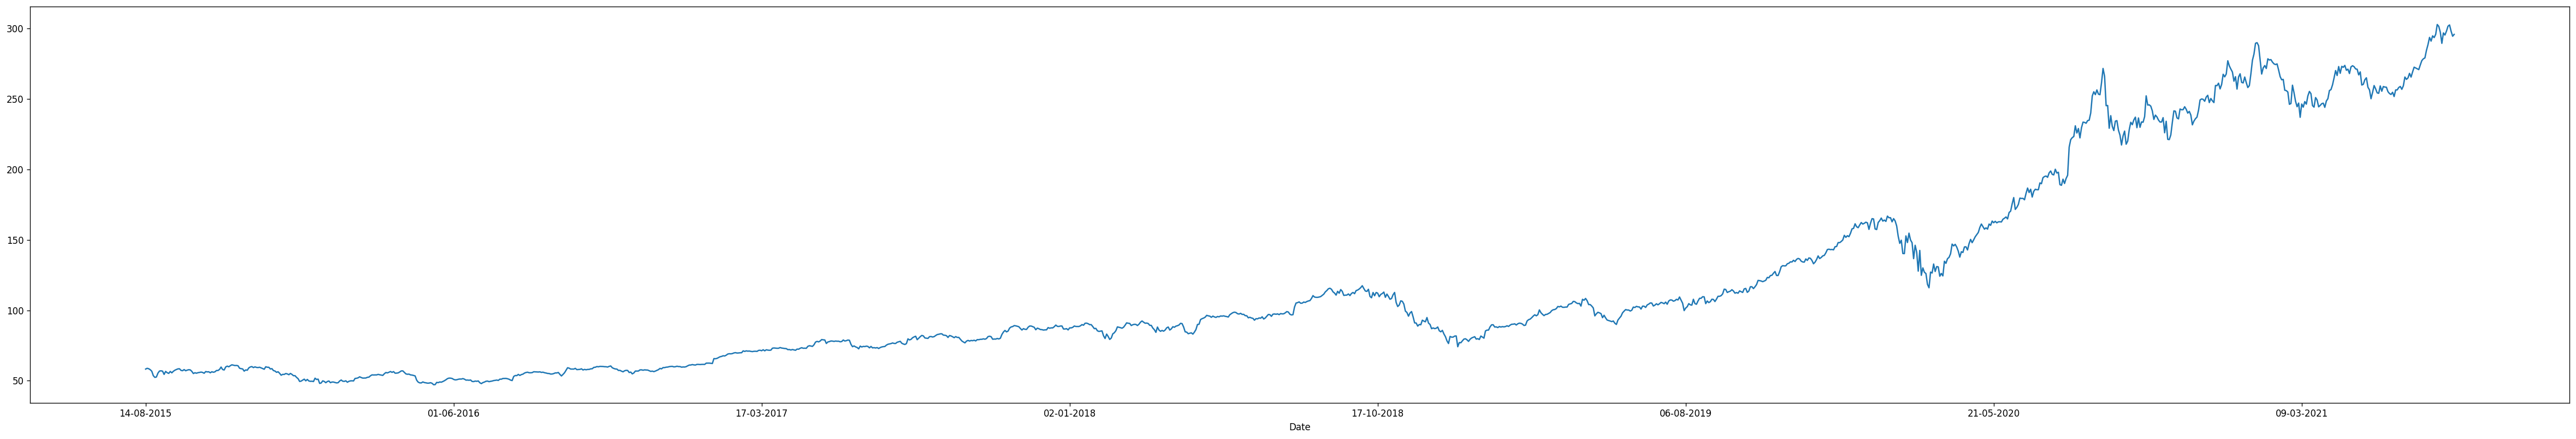

In [59]:
# Plot of Close VS Time
df['Close'].plot(figsize = (50,8))

### Plotting graphs to check:
1. Spread of data in each column - histogram
2. Correlation between the data - heatmap and pair plot

array([[<AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Open'}>],
       [<AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>],
       [<AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'Close'}>]], dtype=object)

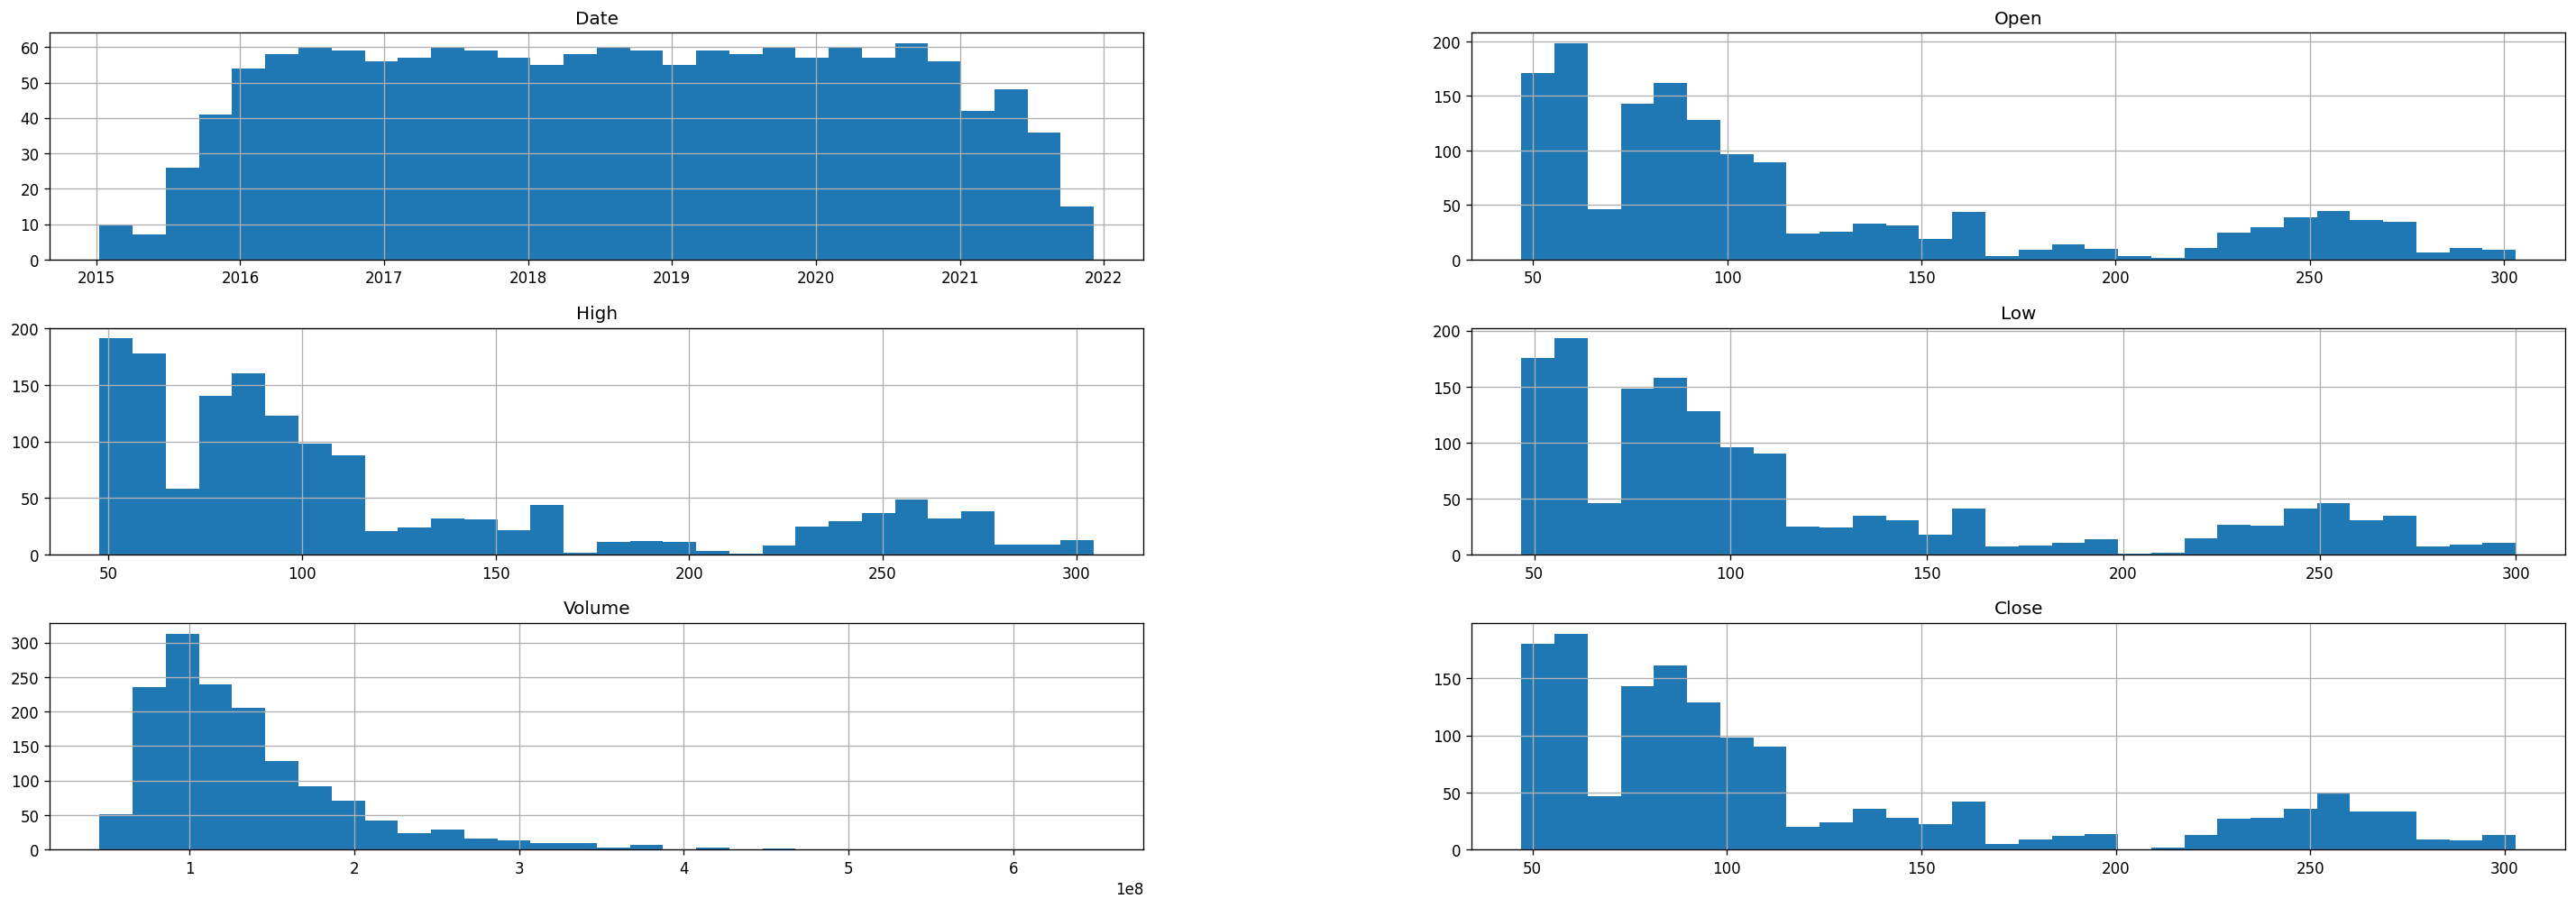

In [60]:
df.hist(bins=30, figsize=(30, 10))

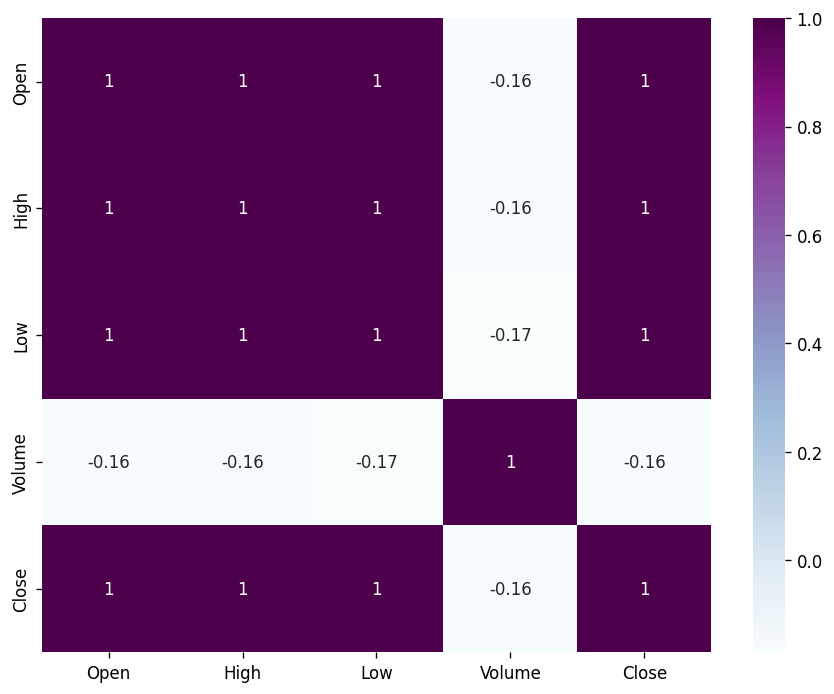

In [61]:
plt.figure()
dataplot = sns.heatmap(df.corr(method = "pearson"), annot = True, cmap="BuPu")

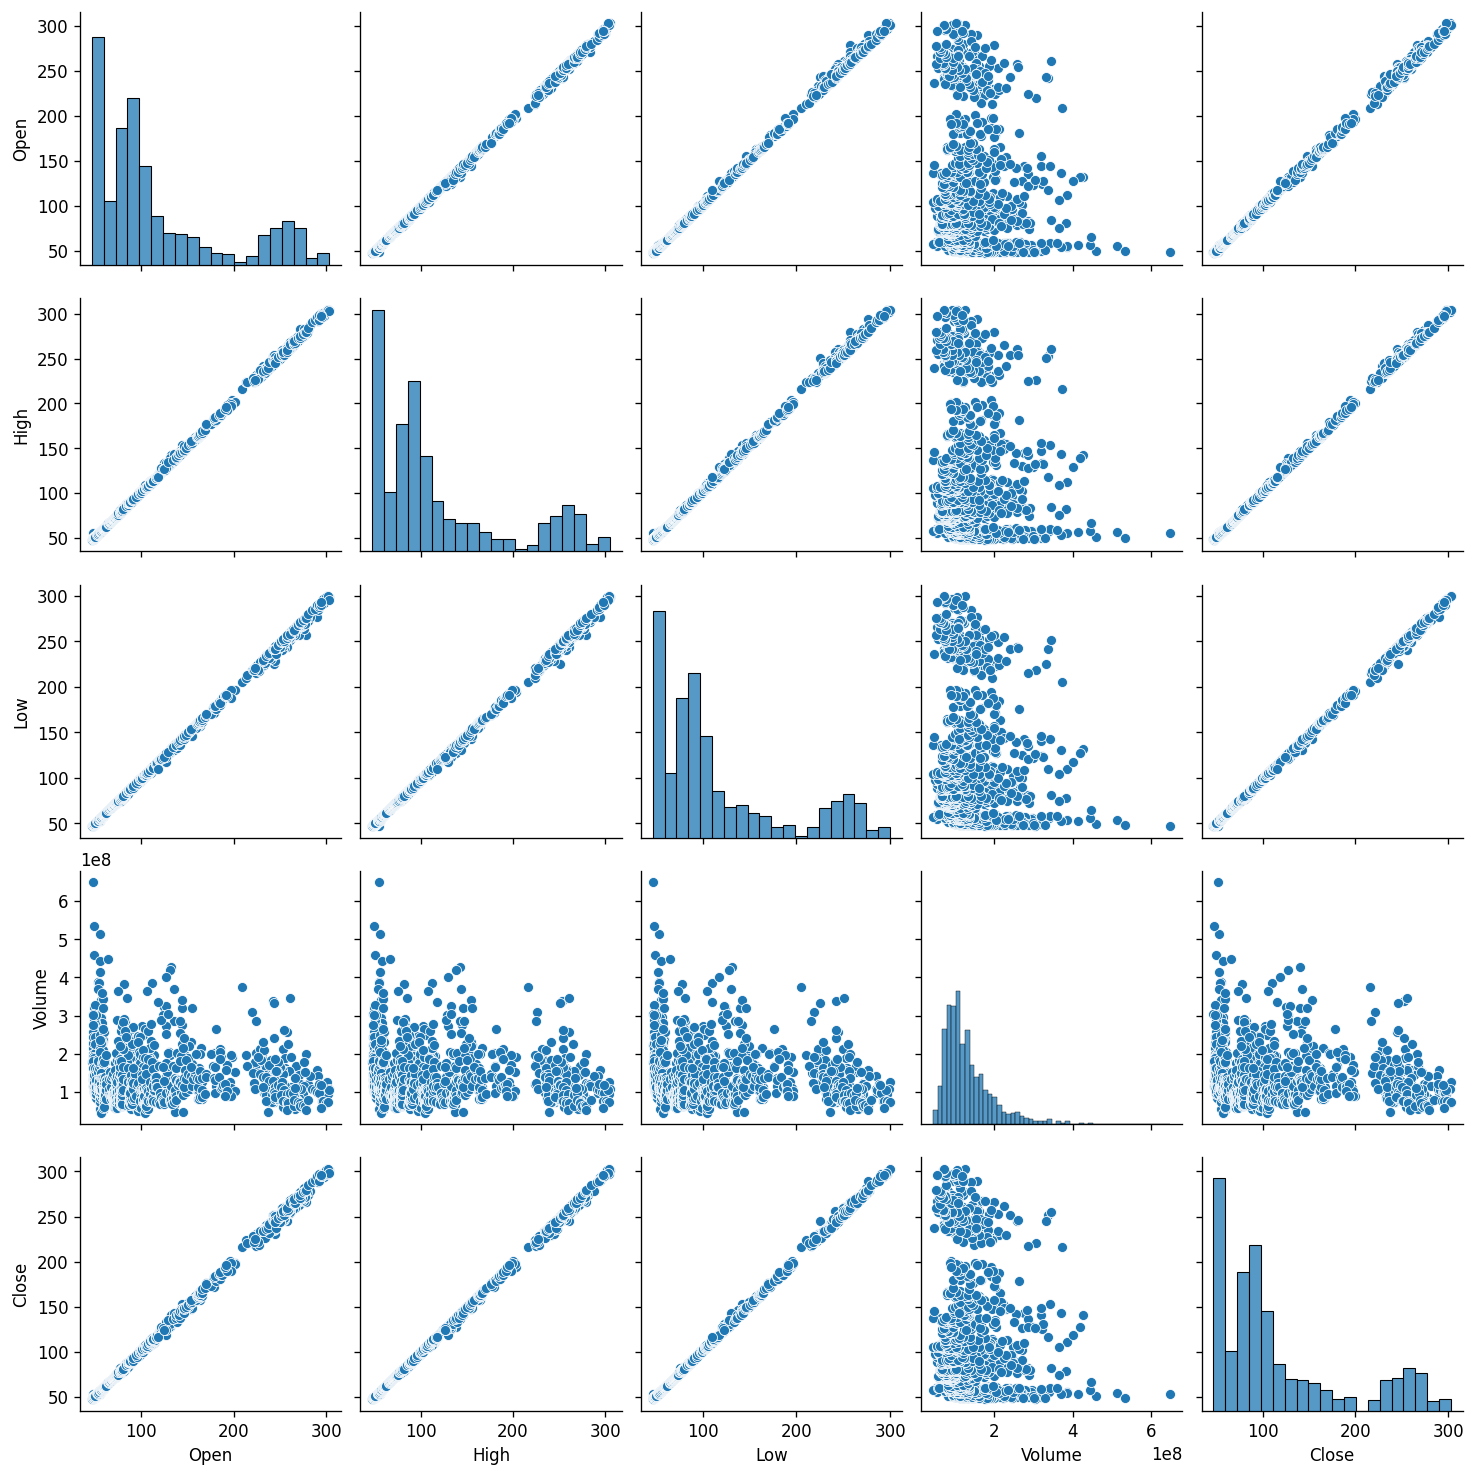

In [62]:
sns.pairplot(df)

Through the pair plots and heatmaps we can conclude that the predictor variables 'Open', 'Low', 'High' are highly linearly correlated with the target variable 'Close'.

There is no significant difference between 'Close' and 'Volume'.

### VIF to check for multi-collinearity


In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

  
# the independent variables set
X = df[['Open', 'High', 'Low', 'Volume']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

  feature           VIF
0    Open  14544.605261
1    High  11890.886948
2     Low   8172.422753
3  Volume      2.316143


### Residual summary and plots

In [64]:
#import necessary libraries 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

#fit multiple linear regression model
residual_model = ols('Close ~ Open + Low + High + Volume', data=df).fit()

#view model summary
print(residual_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.833e+06
Date:                Sat, 06 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:02:23   Log-Likelihood:                -2118.6
No. Observations:                1500   AIC:                             4247.
Df Residuals:                    1495   BIC:                             4274.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2573      0.098      2.632      0.0

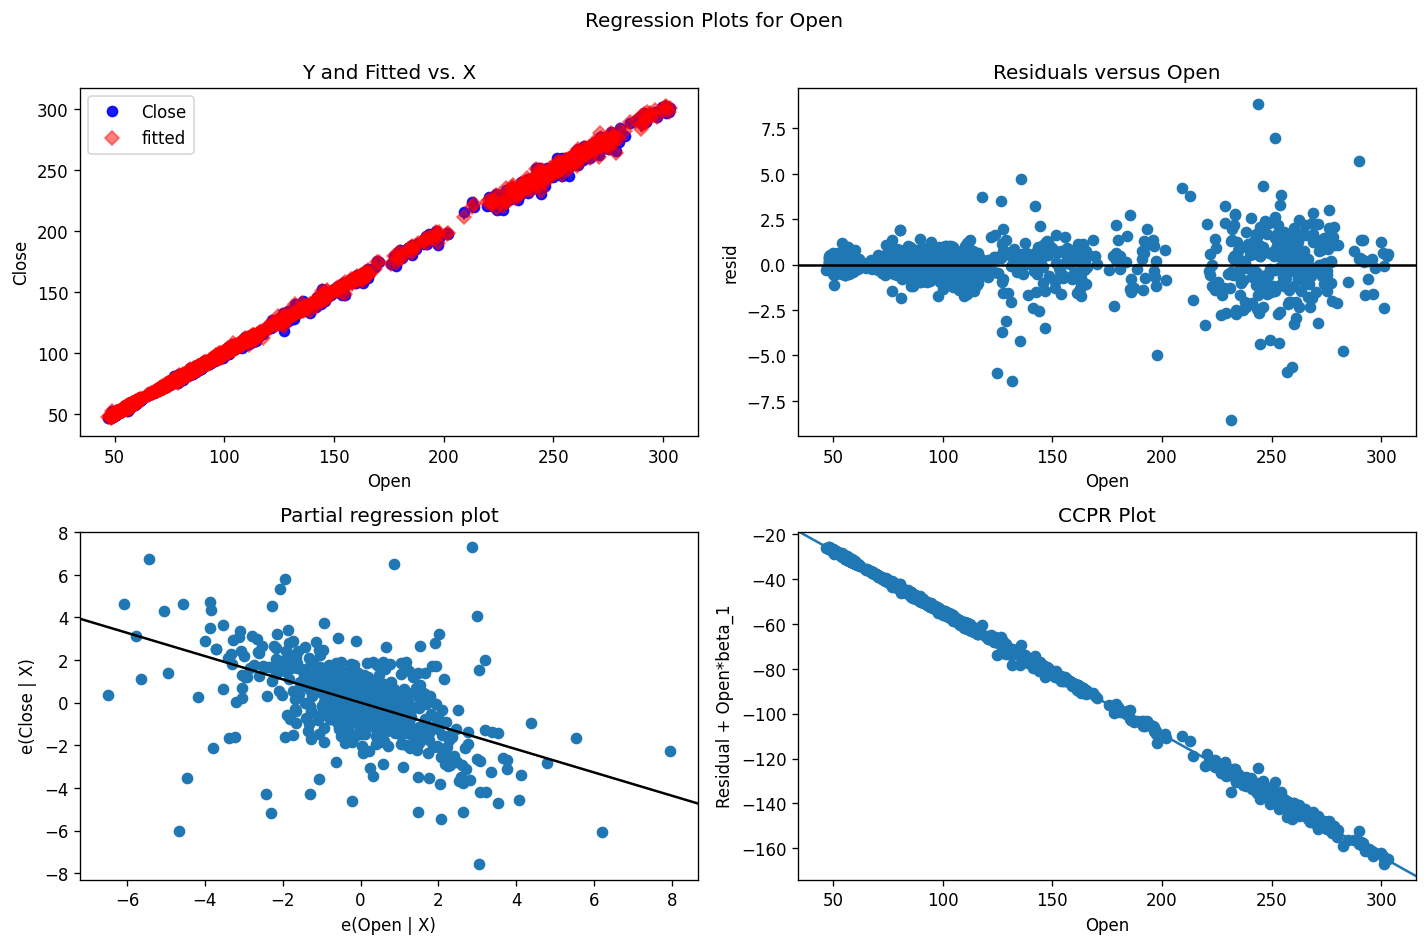

In [65]:
#creating residual vs. predictor plot 
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(residual_model, 'Open', fig=fig)

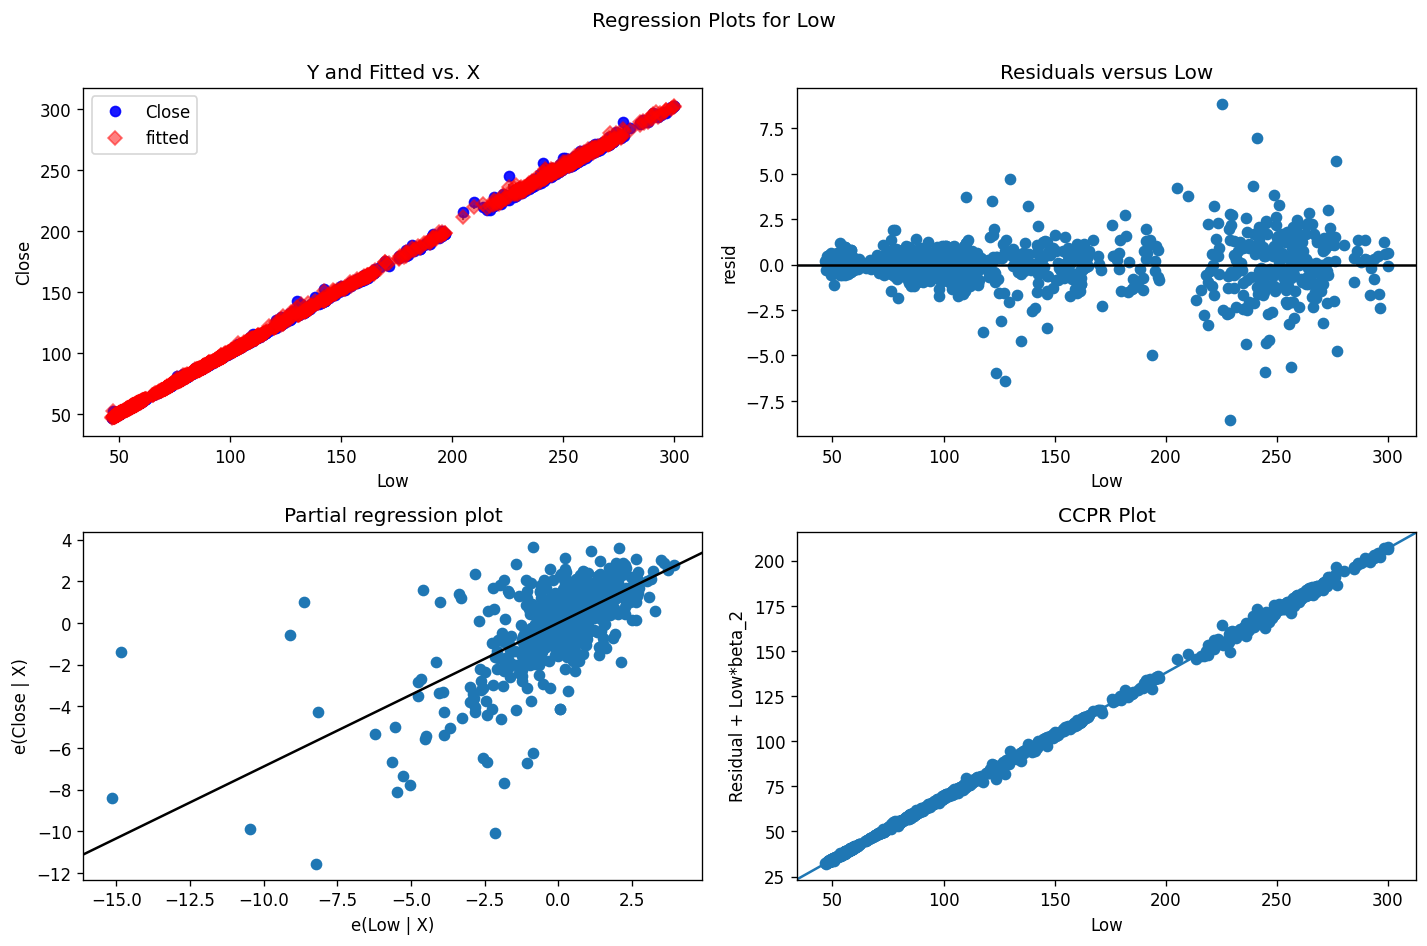

In [66]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(residual_model, 'Low', fig=fig)

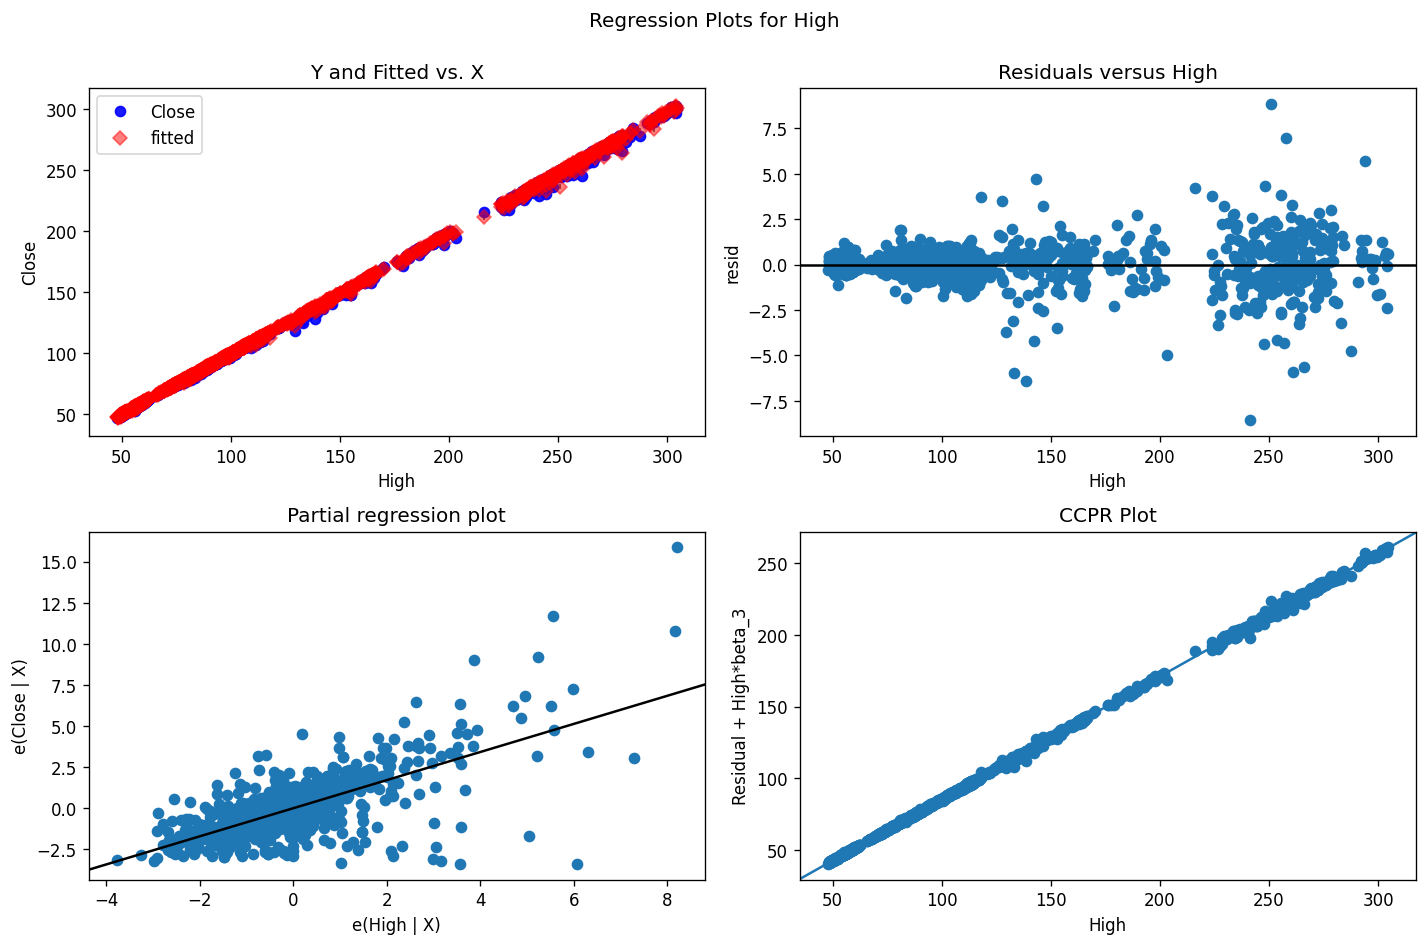

In [67]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(residual_model, 'High', fig=fig)

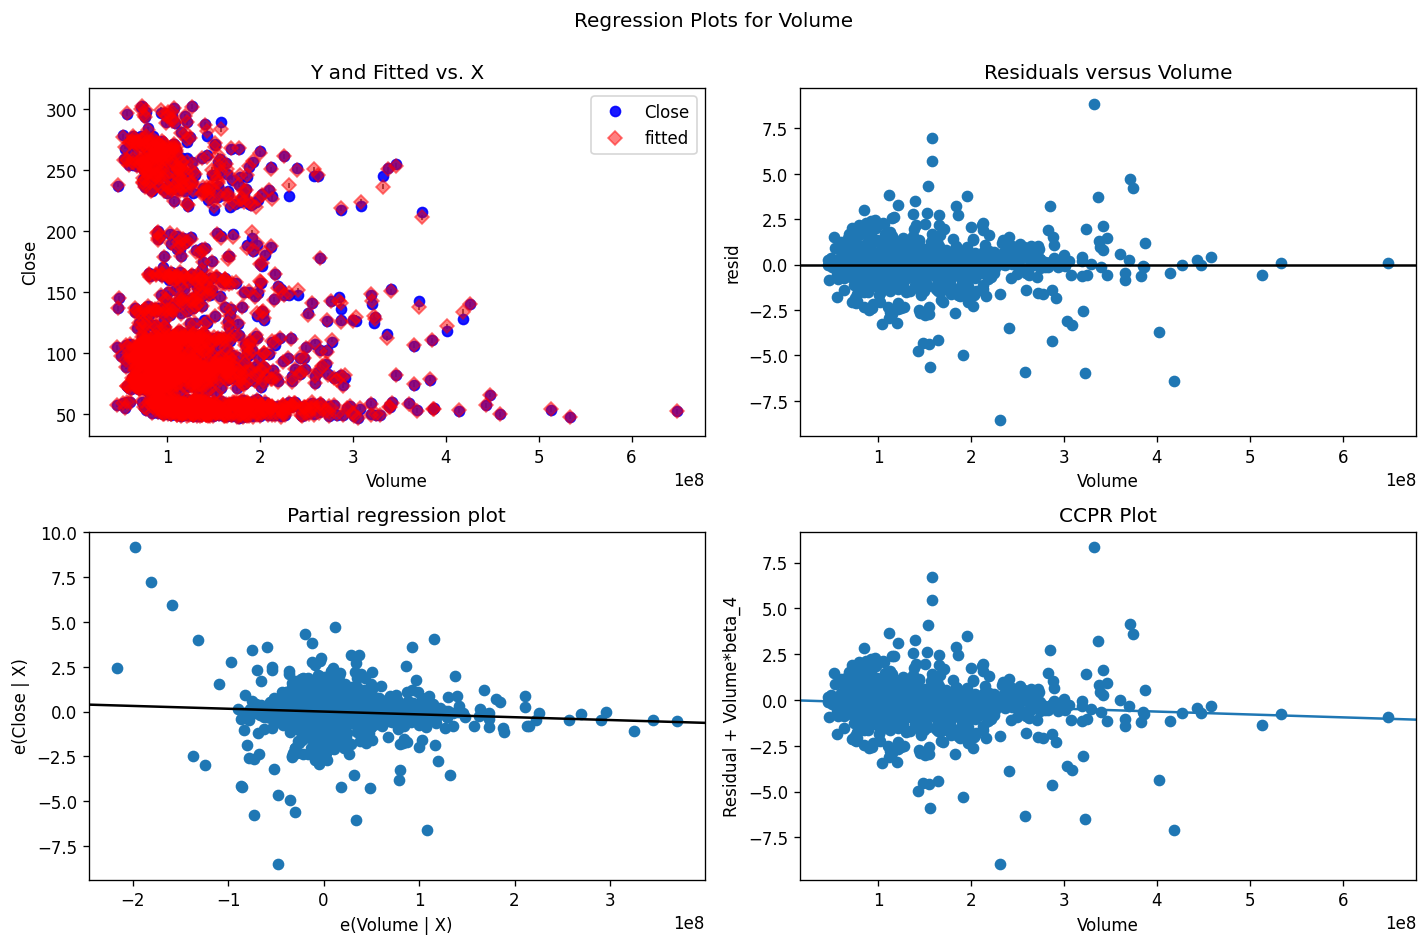

In [68]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(residual_model, 'Volume', fig=fig)

# Regression Model

### Assumptions:
1. The predictor and target variables are highly linearly correlated. This is shown through the scatter plots.
2. The multicollinearity and autocorreclation is assumed to be absent. 
3. We assume that residual plots are normal.

### Rationale - 
From domain knowledge we know that the closing stock price can be influenced by various factors like the Opening price, number of shares bought (Volume), etc. Hence, we decided to use all these variables in a **Multiple Regression Model** to train our model

### Training the model - 


In [69]:
predictor = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close']

### Train-test split:

We have split the train and test data using **cross fold validation**. Upon inspection of the model, we noticed that the stock prices go up during 2020-21. Hence, using a 80:20 split would not result in an accurate prediction of the data. 

We used **cross-fold validation of a 75:25 data split**. After trial and error we found this to be the best split for the data with the least RMSE value of 1.01086. 

In [70]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(predictor, target,test_size=0.25,random_state=0)
print("Shape of training data: ",train_x.shape)
print("Shape of test data: ",train_y.shape)

Shape of training data:  (1125, 4)
Shape of test data:  (1125,)


### We have used StandardScalar() in our model for pre-processing to ensure that our data fits the bell curve and so that there are no values that have high fluctuations influencing the fit of the model.

In [71]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


clf = Pipeline(steps=[('scalar', StandardScaler()),
                      ('classifier', LinearRegression())])
clf.fit(train_x,train_y)
predictions = clf.predict(train_x)
predict_test  = clf.predict(test_x)

print('RMSE on train data: ')
print(np.sqrt(np.mean(predictions- train_y)**2))
print('RMSE on test data: ')
print(np.sqrt(np.mean(predict_test- test_y)**2))
predictions


RMSE on train data: 
4.0920945644352793e-14
RMSE on test data: 
0.07225884427555539


array([ 55.62954196,  84.20789452,  94.7814278 , ..., 174.94994764,
        84.5534123 ,  89.65509392])

### The parameters of the model are the co-efficients and intercept of the multi linear regression model.

Hence the equation for the model linear regression is: 

(Close) = -5.34531020e-01(Open) + 8.86297601e-01(Low) +  6.45732718e-01(High) -1.93010552e-09(Volume) + 0.31859301233799897

In [72]:
predicted=clf.predict(test_x)
test_x

Open        High         Low     Volume
Date                                                     
28-06-2017   73.679732   74.449756   73.047548   88329600
27-08-2015   56.525265   56.988958   55.510642  338464400
29-07-2021  293.947087  297.661523  293.727415   56699500
30-10-2015   60.547025   60.652621   59.840004  197461200
24-03-2021  249.856610  250.016104  244.374151   88530500
...                ...         ...         ...        ...
01-12-2015   59.751996   59.779659   58.880575  139409600
13-07-2017   74.159832   75.581058   74.131314  100797600
23-12-2020  268.083900  268.621352  265.336797   88223700
03-08-2018  104.936272  105.761717  104.188064  133789600
12-01-2021  260.798125  263.166999  257.533465   91951100

[375 rows x 4 columns]

In [73]:
dframe=pd.DataFrame(test_y,predicted)
dfr=pd.DataFrame({'Actual Price': train_y, 'Predicted Price': predictions})
dfr

Actual Price  Predicted Price
Date                                     
08-08-2016     55.816883        55.629542
25-04-2018     83.692688        84.207895
27-06-2018     93.896599        94.781428
15-12-2017     88.315483        87.879598
11-05-2016     48.146088        48.296083
...                  ...              ...
24-08-2018    109.709412       109.504531
07-12-2018     86.902496        87.800820
15-06-2020    175.092346       174.949948
01-11-2017     84.638519        84.553412
03-05-2018     90.059273        89.655094

[1125 rows x 2 columns]

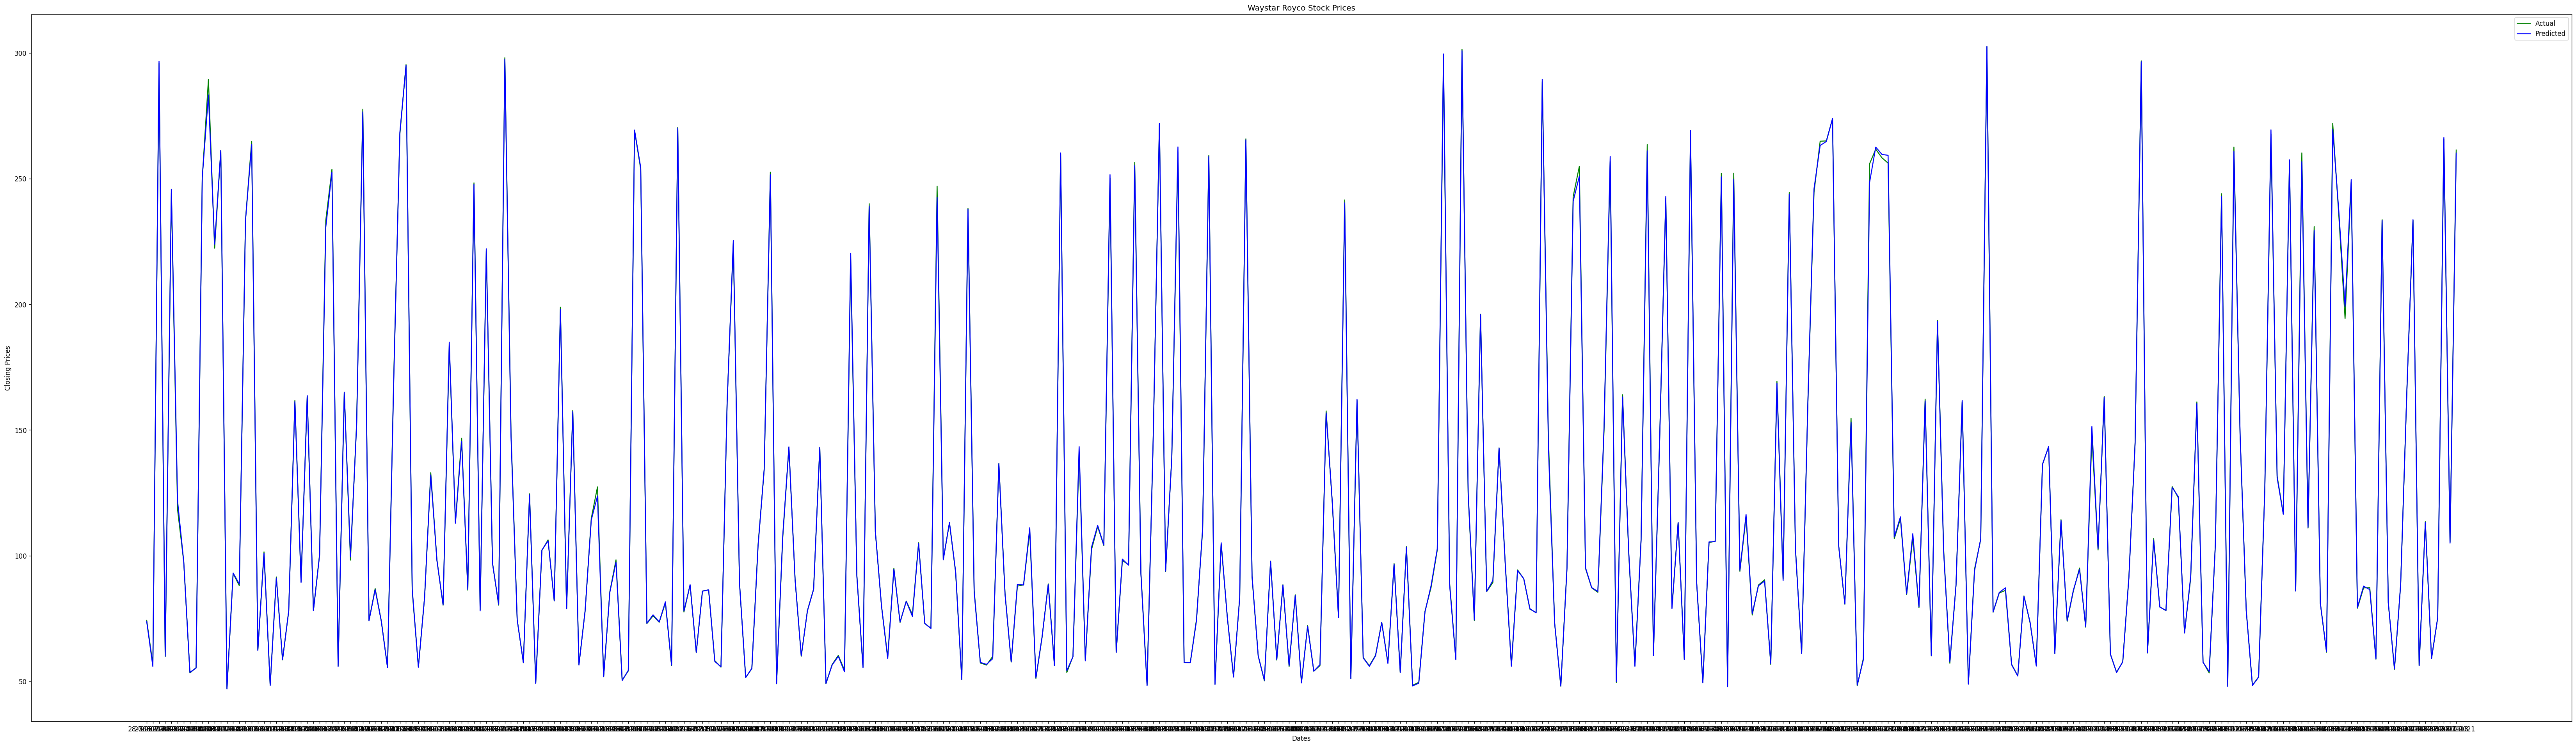

In [74]:
plt.figure(figsize=(70,20))
plt.title('Waystar Royco Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_y, 'green', label='Actual')
plt.plot(predict_test, 'blue', label='Predicted')
plt.legend()

### Predicting for test.csv

In [75]:
df1=pd.read_csv("../input/ue19cs312-assignment/test.csv")

df1.index=df1['Date']
df1.head()

Date        Open        High         Low    Volume  Close
Date                                                                       
30-07-2021  30-07-2021  293.328006  297.222166  292.788806  70382000    NaN
02-08-2021  02-08-2021  297.282094  298.460321  295.065414  62880000    NaN
03-08-2021  03-08-2021  296.183715  300.637034  294.925590  64786600    NaN
04-08-2021  04-08-2021  299.099384  300.137807  297.122335  56368300    NaN
05-08-2021  05-08-2021  298.520228  300.237657  296.902657  46397700    NaN

In [76]:
x1 = df1[['Open', 'High', 'Low', 'Volume']]
y1 = df1['Close']

predicted1=clf.predict(x1)
x1 = pd.DataFrame(x1)
x1

Open        High         Low     Volume
Date                                                     
30-07-2021  293.328006  297.222166  292.788806   70382000
02-08-2021  297.282094  298.460321  295.065414   62880000
03-08-2021  296.183715  300.637034  294.925590   64786600
04-08-2021  299.099384  300.137807  297.122335   56368300
05-08-2021  298.520228  300.237657  296.902657   46397700
06-08-2021  297.700012  299.220001  296.260010   54067400
09-08-2021  297.399994  298.399994  296.040008   48908700
10-08-2021  297.880005  300.420013  295.600006   69023100
11-08-2021  297.100006  298.440002  296.059998   48493500
12-08-2021  297.380005  303.100006  296.679993   72282600
13-08-2021  302.940002  303.880005  301.540008   59318800
16-08-2021  302.079987  307.380005  297.940002  103296000
17-08-2021  305.459992  308.359985  303.179993   92229700
18-08-2021  304.600006  306.440002  297.299988   86326000
19-08-2021  295.059998  301.000000  294.000000   86960300
20-08-2021  299.880005  302.000000  298.559998   59947400
23-08-2021  301.619995  305.380005  300.779999   60131800
24-08-2021  303.899994  306.720001  303.299988   48606400
25-08-2021  304.619995  305.640015  300.600006   58991300
26-08-2021  301.700012  303.239990  300.019989   48597200
27-08-2021  299.959992  302.500000  298.660004   55721500
30-08-2021  303.000000  311.980011  302.220001   90956700
31-08-2021  310.320007  310.600006  307.579987   86453100
01-09-2021  310.660004  314.959992  309.679993   80313700
02-09-2021  312.739990  314.440002  309.799988   71115500
03-09-2021  312.519989  314.260010  311.179993   57808700
07-09-2021  314.940002  319.519989  313.779999   82278300
08-09-2021  318.959992  319.079987  312.959992   74420200
09-09-2021  315.980011  317.220001  312.899994   57305700
10-09-2021  315.000000  315.959992  302.399994  140646400

In [77]:
dframe1=pd.DataFrame(predicted1)
dfr1=pd.DataFrame({'Predicted Price': predicted1})
dfr1

Predicted Price
0        295.942947
1        296.440187
2        298.734987
3        298.322714
4        298.575613
5        297.716055
6        297.052675
7        298.104416
8        297.267109
9        301.372234
10       302.497845
11       303.172951
12       305.949002
13       300.550470
14       298.957024
15       300.468930
16       303.906536
17       305.598828
18       302.324749
19       301.558338
20       300.913089
21       309.589021
22       308.319385
23       313.258244
24       311.773581
25       312.771254
26       317.630353
27       314.445436
28       314.543728
29       306.282180

## Writing to submission.csv

In [78]:
sub = pd.read_csv("../input/ue19cs312-assignment/submission.csv")
sub.head()

sub['Close'] = dfr1
sub.to_csv("./submission.csv",index=False)

### Metadata of submission.csv - 

In [79]:
print(sub)

          Date       Close
0   30-07-2021  295.942947
1   02-08-2021  296.440187
2   03-08-2021  298.734987
3   04-08-2021  298.322714
4   05-08-2021  298.575613
5   06-08-2021  297.716055
6   09-08-2021  297.052675
7   10-08-2021  298.104416
8   11-08-2021  297.267109
9   12-08-2021  301.372234
10  13-08-2021  302.497845
11  16-08-2021  303.172951
12  17-08-2021  305.949002
13  18-08-2021  300.550470
14  19-08-2021  298.957024
15  20-08-2021  300.468930
16  23-08-2021  303.906536
17  24-08-2021  305.598828
18  25-08-2021  302.324749
19  26-08-2021  301.558338
20  27-08-2021  300.913089
21  30-08-2021  309.589021
22  31-08-2021  308.319385
23  01-09-2021  313.258244
24  02-09-2021  311.773581
25  03-09-2021  312.771254
26  07-09-2021  317.630353
27  08-09-2021  314.445436
28  09-09-2021  314.543728
29  10-09-2021  306.282180


In [80]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    30 non-null     object 
 1   Close   30 non-null     float64
dtypes: float64(1), object(1)
memory usage: 608.0+ bytes


Submission.csv has 30 rows and 2 columns(Date and Close) with no null values.

### We also attempted the following methods but they weren't as accurate as the currently implemented model:

1. Scaling the data using MinMaxScalar() and StandardScalar(). This gave innacurate results because the mean, std, max and min (descriptive statistcis) were for the trained data only; it did not scale well for the predicted data

2. Lasso model

In [81]:
from sklearn.linear_model import Lasso
 
lassoReg = Lasso(alpha=0.3, normalize=True, tol=1e-2)
 
lassoReg.fit(train_x,train_y)
 
pred_l = lassoReg.predict(test_x)
pred_lasso = lassoReg.predict(x1)
print("Predicted values for Lasso regression:\n\n ",pred_lasso) 
# calculating mse
 
rmse = math.sqrt(np.mean((pred_l - test_y)**2))
 
print("\n\nRMSE value: ",rmse) 


Predicted values for Lasso regression:

  [267.70329212 271.07716885 270.14191019 272.62877104 272.13482469
 271.43437348 271.17783218 271.58869037 270.92199209 271.16437209
 275.90804645 275.17656372 278.06103182 277.32520493 269.18357339
 273.29619611 274.78315522 276.72924002 277.34215382 274.84970085
 273.36480683 275.96534371 282.20867732 282.50223047 284.27597411
 284.08839819 286.15683337 289.5852095  287.04206121 286.20365813]


RMSE value:  10.6051333337263


3. Ridge Regression

In [82]:
from sklearn.linear_model import Ridge
 
## training the model
 
ridgeReg = Ridge(alpha=0.05, normalize=True)
 
ridgeReg.fit(train_x,train_y)
 
pred_r = ridgeReg.predict(test_x)
pred_ridge = ridgeReg.predict(x1)
print("Predicted values for Ridge regression:\n\n ",pred_ridge)
 
#calculating mse
 
rmse = math.sqrt(np.mean((pred_r - test_y)**2))
 
print("\n\nRMSE value: ",rmse)


Predicted values for Ridge regression:

  [291.84213769 294.31481442 294.61300794 296.1601057  295.9670712
 295.12785143 294.70879057 295.3027792  294.63261222 296.36112964
 300.08765657 299.58811069 302.79223991 299.94736048 293.97802276
 297.48621909 299.89071861 301.94889028 300.89290348 299.00819579
 297.72336591 302.85578886 306.5872997  308.83890555 309.41777043
 309.79607372 313.07261868 313.98857435 312.45772504 307.92681725]


RMSE value:  1.768126812628135


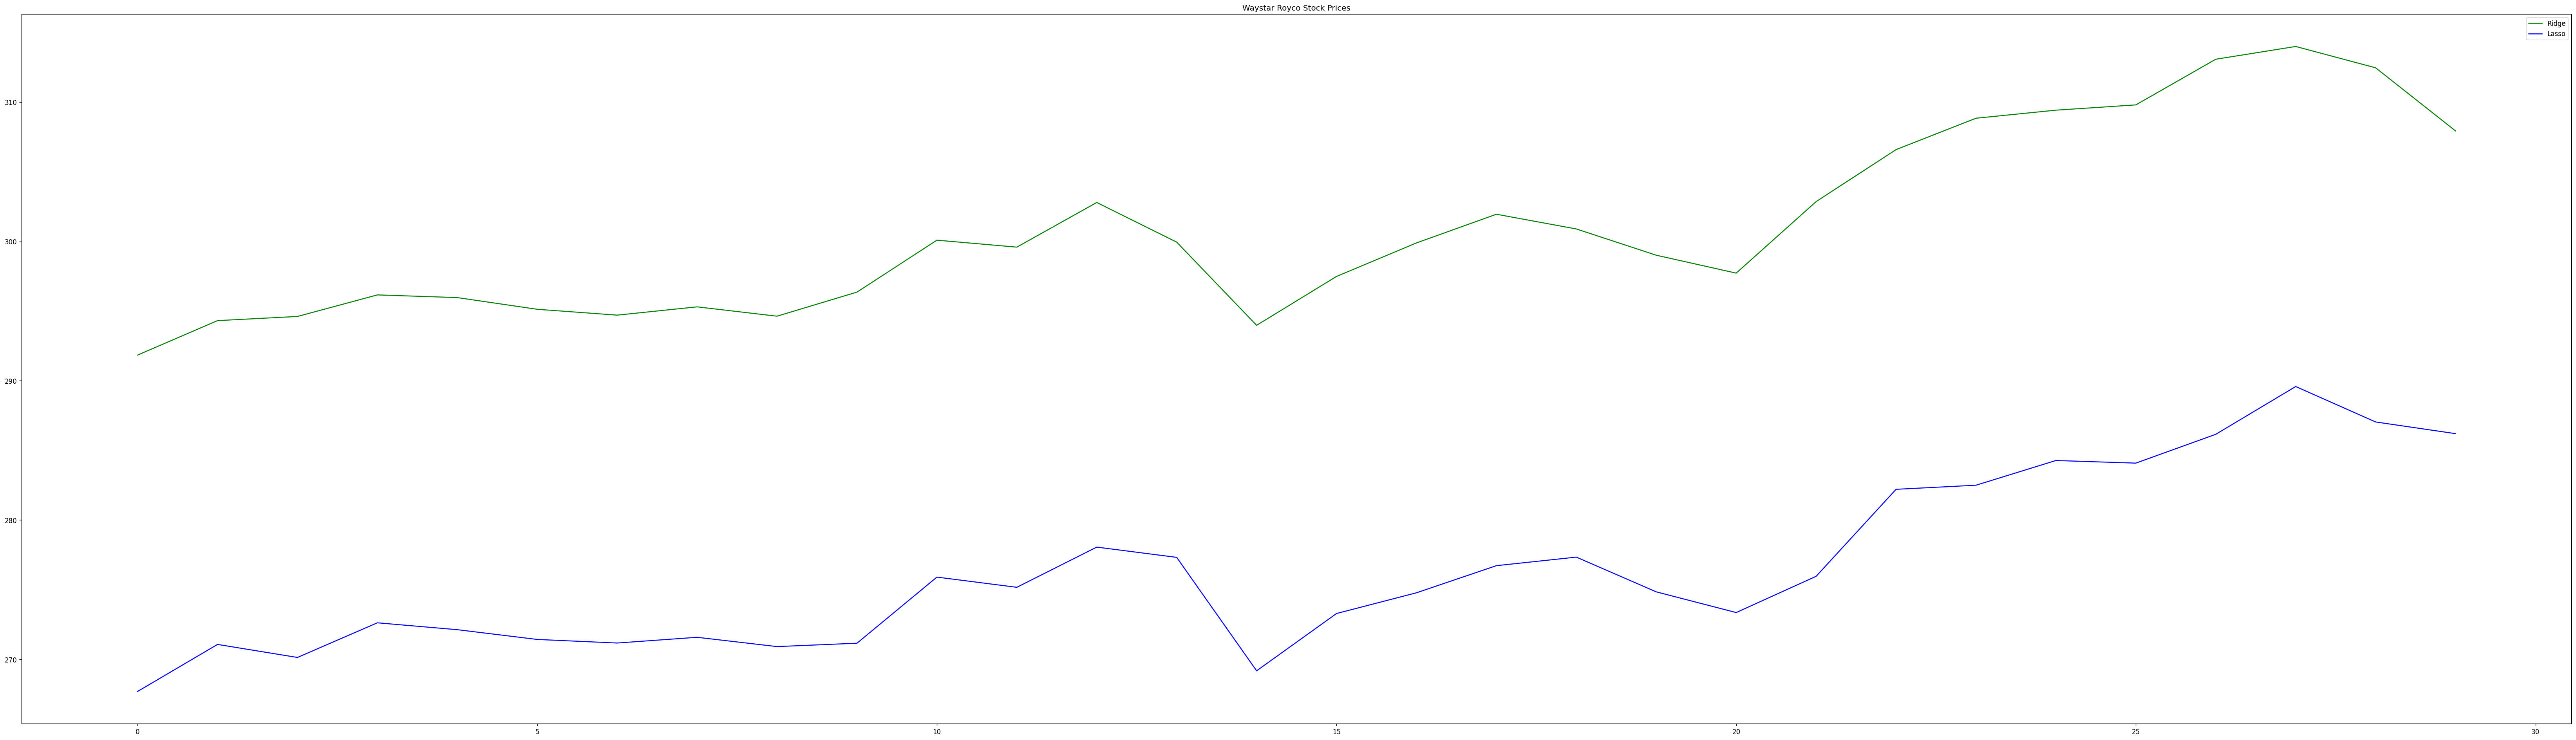

In [83]:
# Graph for predicted values of Lasso and Ridge
plt.figure(figsize=(70,20))
plt.title('Waystar Royco Stock Prices')
plt.plot(pred_ridge, 'green', label='Ridge')
plt.plot(pred_lasso, 'blue', label='Lasso')
#plt.plot(df['Close'], 'red', label = 'actual data')
plt.legend()

# Time Series Model

In [ ]:
!pip install pmdarima

In [84]:
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

<AxesSubplot:xlabel='Date'>

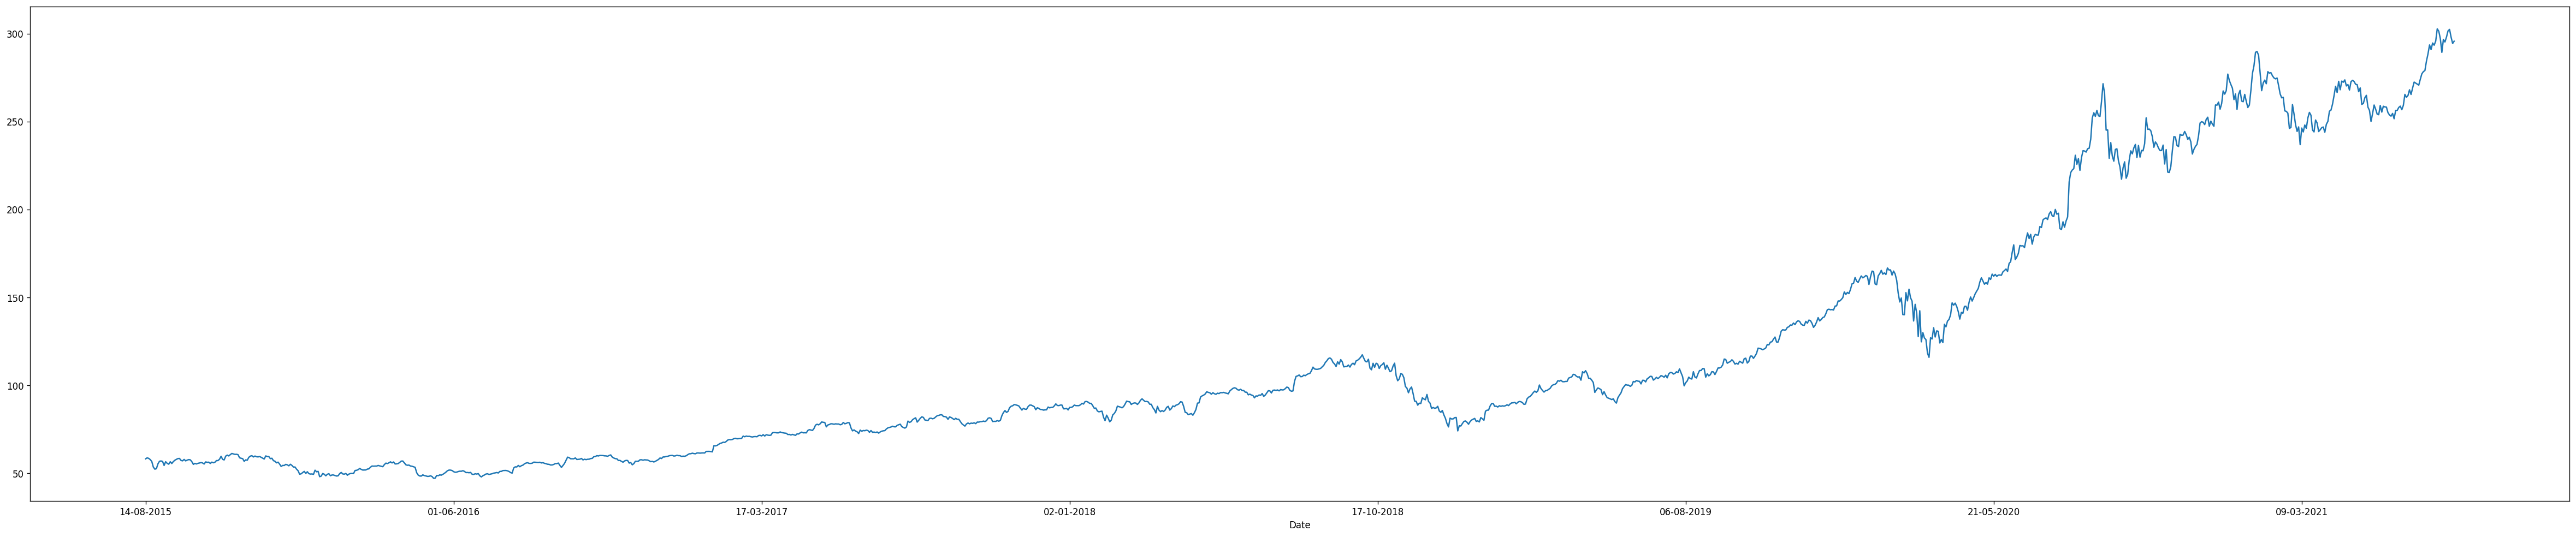

In [85]:
df['Close'].plot(figsize = (50,10))

### Analysing the graph:

1. This graph seems to be an additive model as the seasonal and residual components seem independent of the trend. 

<Figure size 1080x840 with 0 Axes>

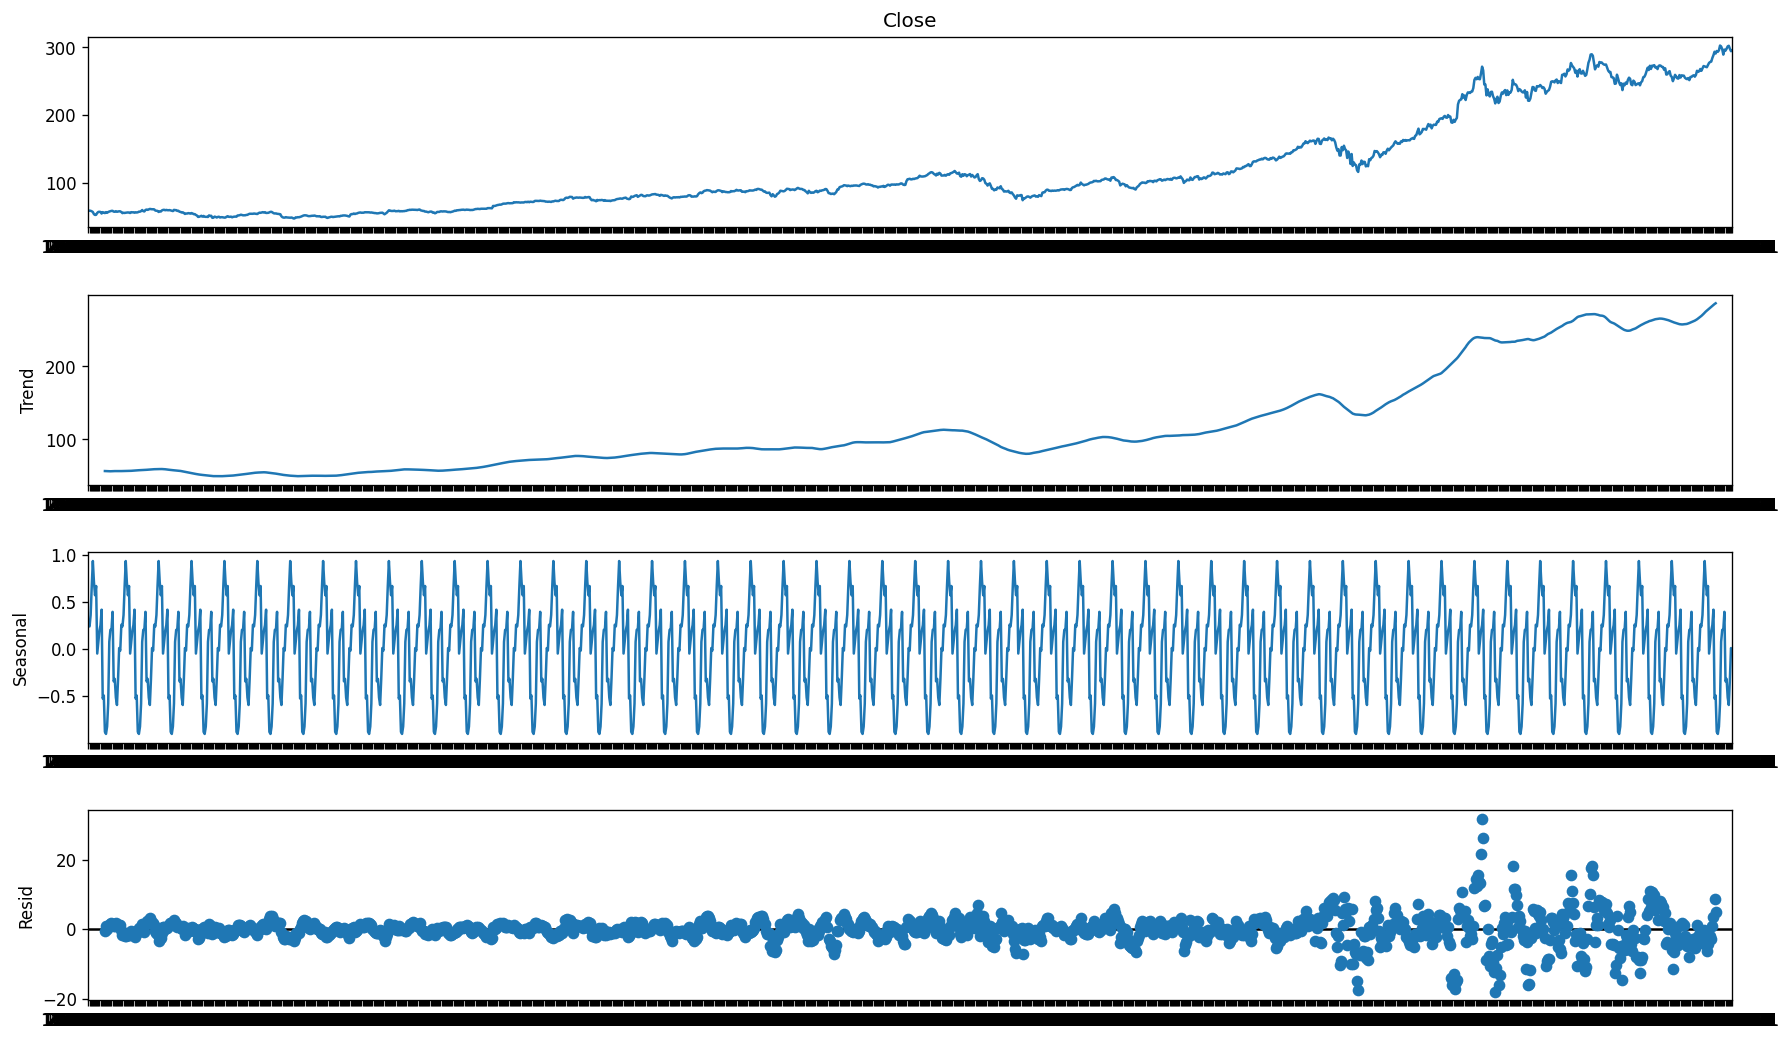

In [88]:
result = seasonal_decompose(df['Close'], model='additive', freq = 30)
fig1 = plt.figure()  
fig1 = result.plot()  
fig1.set_size_inches(16, 9)

### Test of Stationarity:
### Using DF Test:

**Null Hypothesis: The series has a unit root (value of b(beta) =1)**

**Alternate Hypothesis: The series has no beta value.**

If we fail to reject the null hypothesis, we can say that the series is non-stationary.

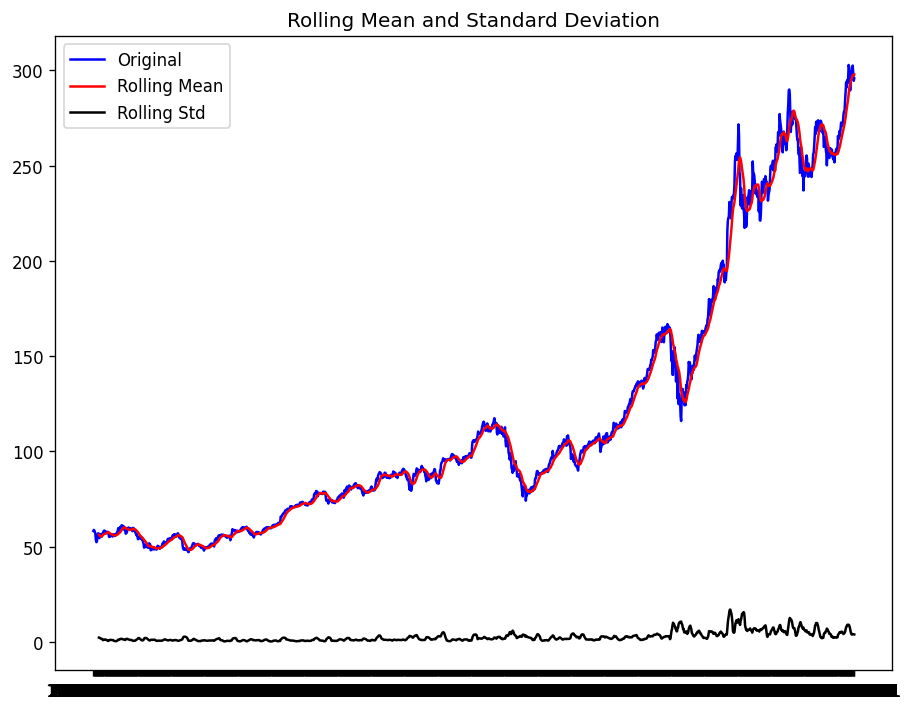

Results of dickey fuller test
Test Statistics                   1.344565
p-value                           0.996847
No. of lags used                 24.000000
Number of observations used    1475.000000
critical value (1%)              -3.434791
critical value (5%)              -2.863501
critical value (10%)             -2.567814
dtype: float64


In [90]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

The test-statistic value is greater than the p-value.  
Hence, the data is non stationary as we fail to reject null hypothesis. 

### Assumptions:
1. **Future trends will hold similar to historical trends:** Since the data is that of stock closing prices, it is safe to assume that the we can forecast into the future using the data we currently have.
2. Since our data is proved to be **non-stationary**, we can use ARIMA models for forecasting. 

### Rationale: 
Generally, timeseries forecasting is used to solve bussiness questions. In stock data, it would be insightful to analyse the trend and seasonality of the data and how they vary over time. Usually, stock closing prices are dependent on the past history of stock market closing prices. This is exactly how time series predictions are made.

We intend to train an ARIMA model. 

### Paramaters:

The paramters in the ARIMA model are p,d,q where p is the p is the number of autoregressive terms (for the Auto Regression component), d is the number of nonseasonal differences needed until the data is found to be stationarity, and q is the number of lagged forecast errors (for the Moving Average component) in the prediction equation.

1. The model is differenced as follows:

In [91]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

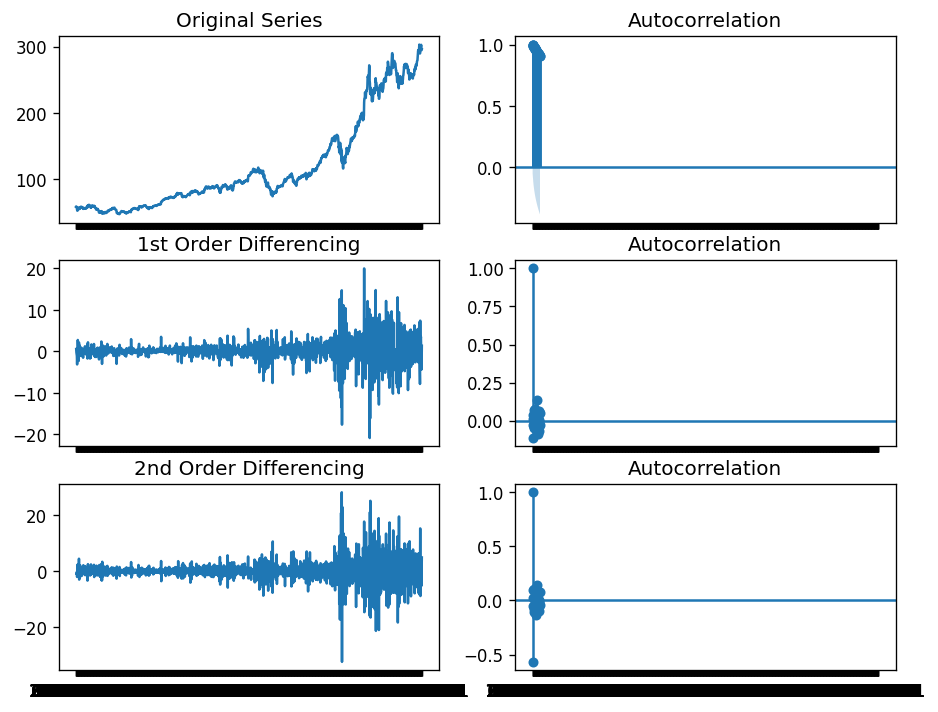

<Figure size 6000x1200 with 0 Axes>

In [92]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.Close); axes[0, 0].set_title('Original Series')
plot_acf(df.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])
plt.figure(figsize=(50,10))
plt.show()

The data is found to be stationary after the first differencing. The plot does not have a pattern and most of the points lie around 0.  
Differencing of 2 is also stationary but the auto-correlation plot gravitates too much towards the negative axis.

### PACF 

<Figure size 3600x1200 with 0 Axes>

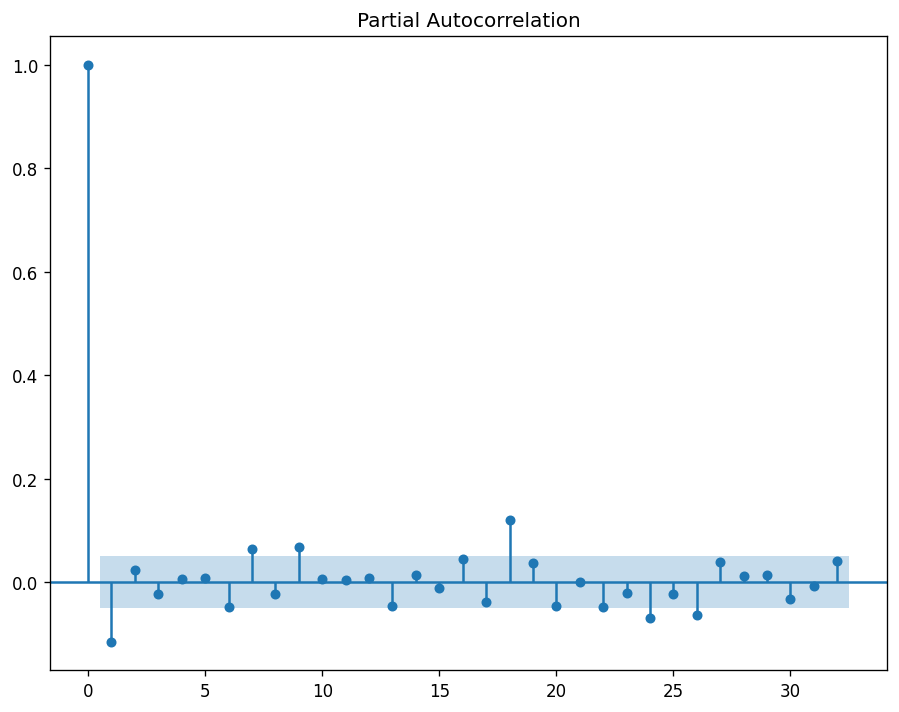

In [98]:
# Plotting PACF with first differencing to determine P

plt.figure(figsize=(30,10))
plot_pacf(df.Close.diff().dropna())

plt.show()

Here, P can be fixed as 1 since there is one statistically significant value in the graph before the next value becomes negative.

### ACF

<Figure size 3600x1200 with 0 Axes>

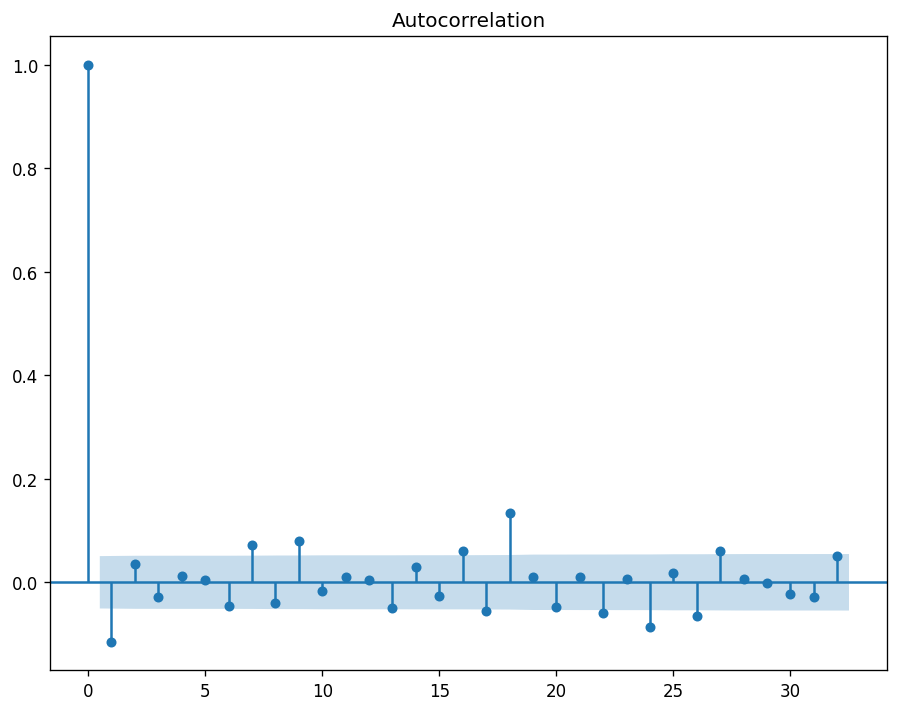

In [99]:
# Plotting ACF with first differencing to determine Q

plt.figure(figsize=(30,10))
plot_acf(df.Close.diff().dropna())

plt.show()

Here, Q can be fixed as 1 since there is one statistically significant value in the graph before the next value becomes negative.

### ARIMA Model

After much trial and error, we found ARIMA(1,2,1) to give the least RMSE.

In [100]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.Close, order=(3,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1498
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -3622.009
Method:                       css-mle   S.D. of innovations              2.709
Date:                Sat, 06 Nov 2021   AIC                           7256.018
Time:                        16:10:13   BIC                           7287.889
Sample:                             2   HQIC                          7267.892
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.000      2.180      0.029    3.18e-05       0.001
ar.L1.D2.Close    -0.1124      0.026     -4.354      0.000      -0.163      -0.062
ar.L2.D2.Close     0.0180      0.026

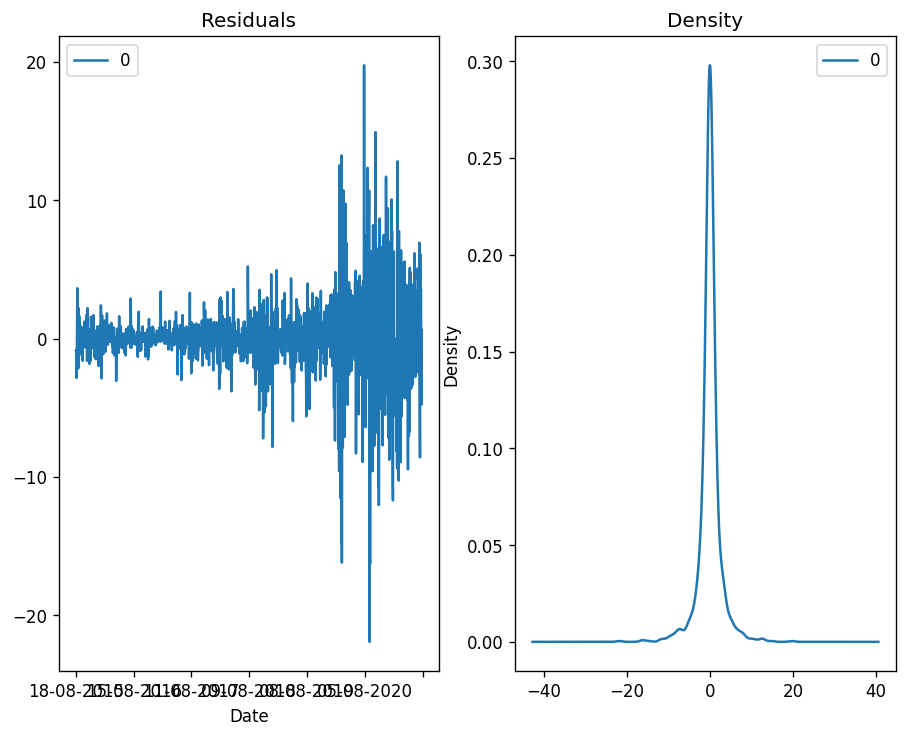

In [101]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual plot on the left seems to almost have a mean of zero. 
Uniform varience can be observed in the plot on the right.

### Fitting the model

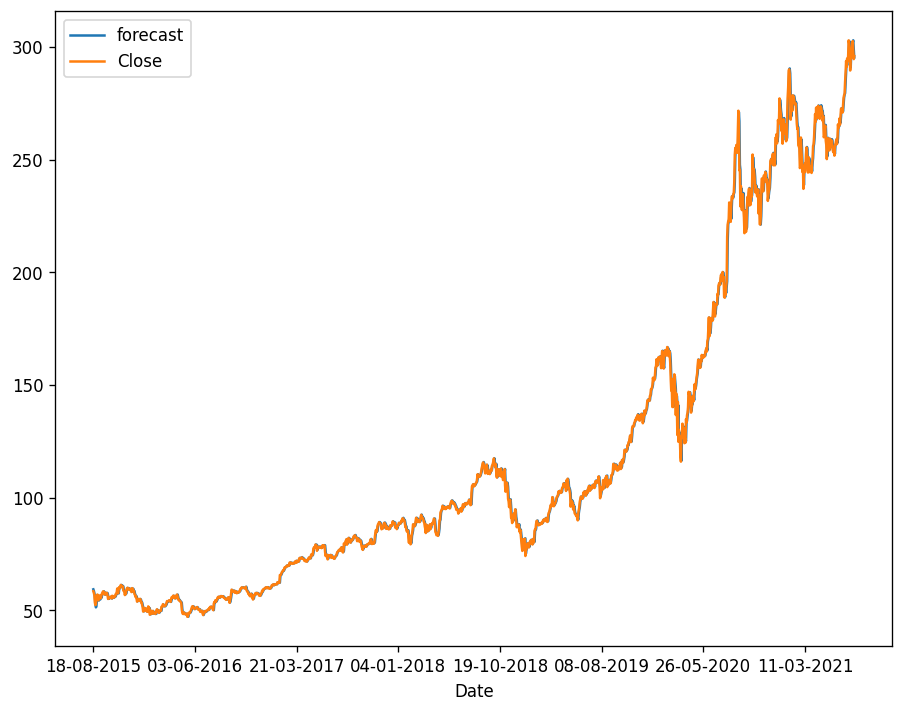

In [102]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

### Forecasting the model for future predictions

In [103]:
# Create Training and Test
train = df.Close #from train.csv
test = df1.Close #from test.csv

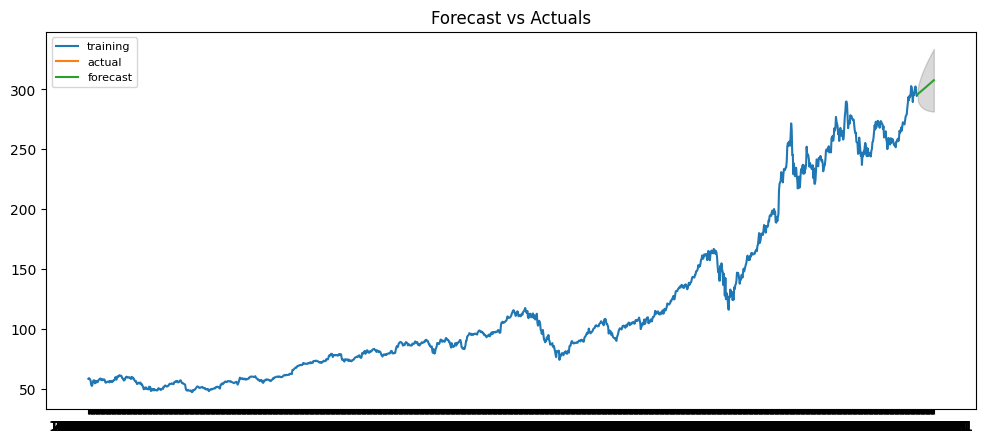

In [104]:
# Build Model
model = ARIMA(train, order=(1,2,1))  
#model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [105]:
# The forecasted values are given by:
fc

array([296.13110068, 296.53853274, 296.93226021, 297.32793743,
       297.72373933, 298.1198787 , 298.51633072, 298.91309829,
       299.31018107, 299.7075791 , 300.10529238, 300.5033209 ,
       300.90166467, 301.30032369, 301.69929795, 302.09858745,
       302.4981922 , 302.8981122 , 303.29834744, 303.69889793,
       304.09976367, 304.50094465, 304.90244088, 305.30425235,
       305.70637907, 306.10882104, 306.51157825, 306.9146507 ,
       307.31803841, 307.72174135])

### This model gave us an RMSE of 6.

## Other time series models we tried:

### 1. Using Auto-ARIMA to find the parameters

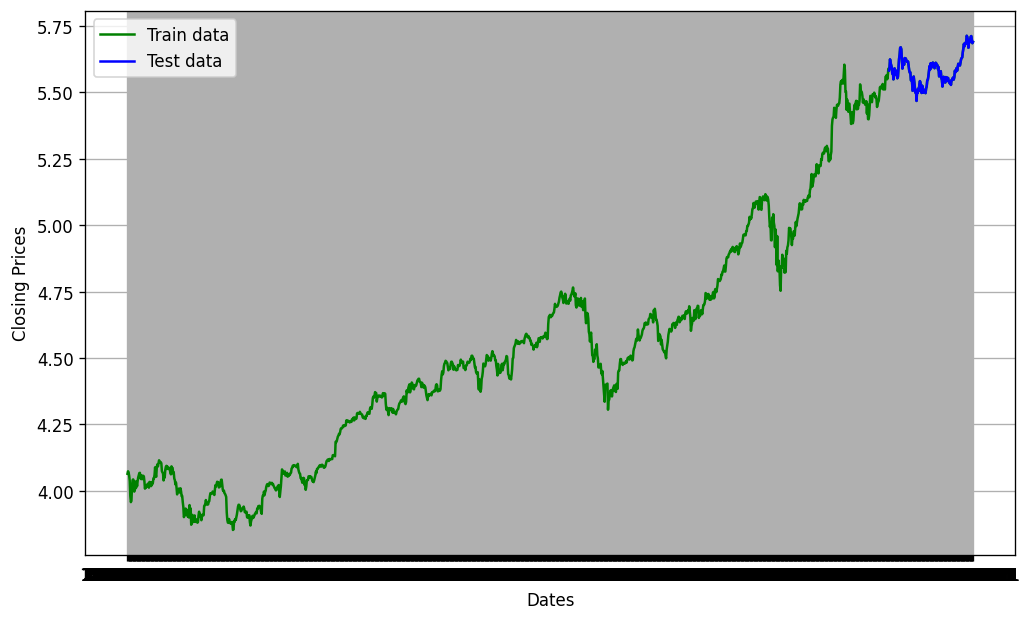

In [106]:
df_log = np.log(df['Close'])
#split data into train and training set

# Trial 1 - 90% train and 10% test
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

#from sklearn.model_selection import train_test_split

#train_data, test_data = train_test_split(df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):],test_size = 0.2, random_state=42)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [107]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6982.372, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6997.587, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6996.860, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6979.034, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6996.020, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6996.117, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7008.457, Time=1.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6992.413, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6991.921, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7005.225, Time=0.88 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6994.433, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6990.522, Time=1.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6988.933, Time=0.16 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 7.621 seconds
         

According to this, we attempted to train ARIMA(2,1,1) on 80:20 train-test split of train.csv and the forecasted the values into test.csv

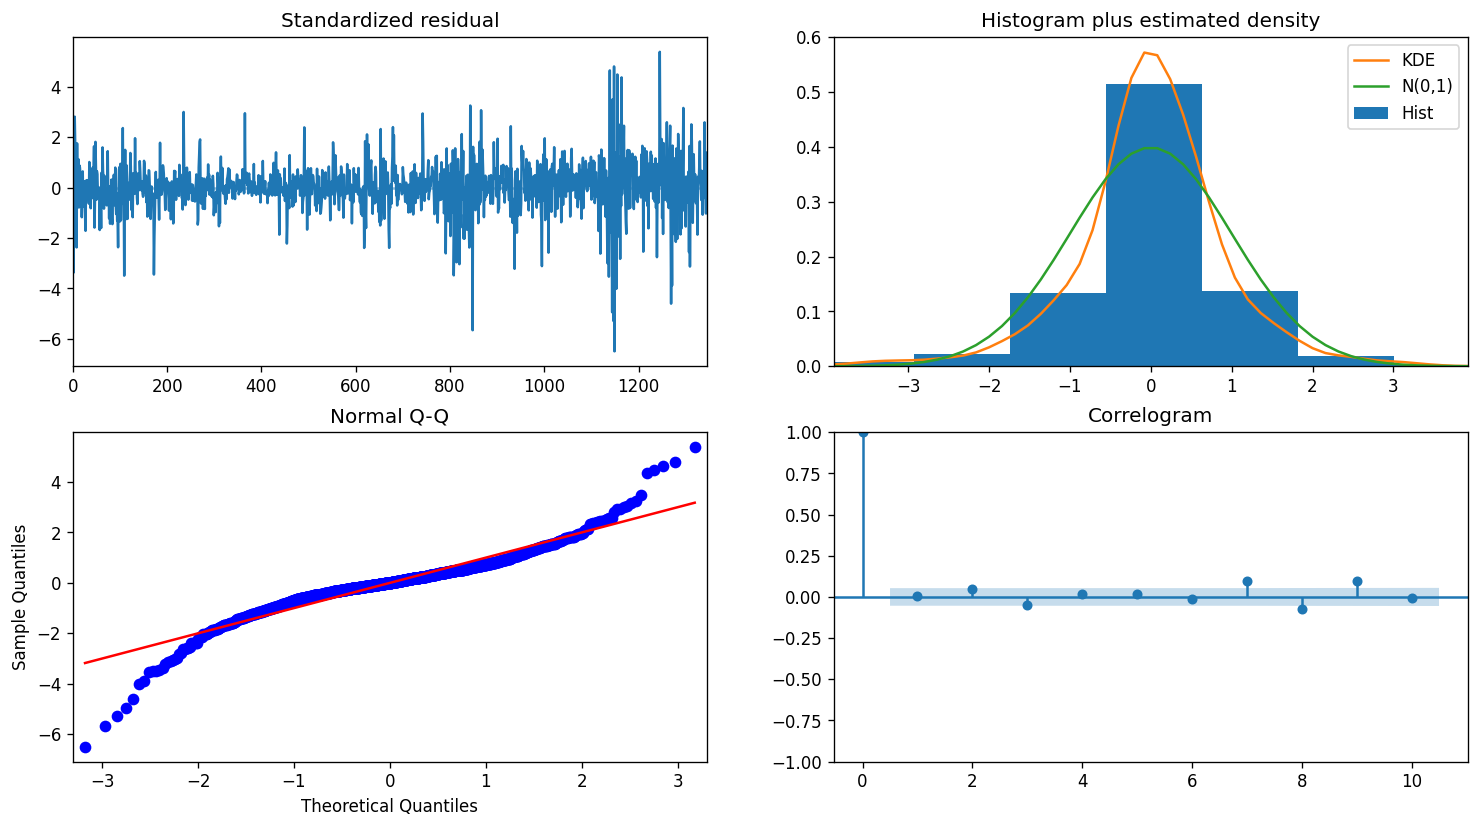

In [108]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Here, the mean seems to be around 0, the variance uniformly distributes and the Q-Q plot seems to be mostly accurate

In [109]:
model = ARIMA(train_data, order=(2, 1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1346
Model:                 ARIMA(2, 1, 1)   Log Likelihood                3502.059
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sat, 06 Nov 2021   AIC                          -6994.118
Time:                        16:11:45   BIC                          -6968.093
Sample:                             1   HQIC                         -6984.370
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      2.545      0.011       0.000       0.002
ar.L1.D.Close    -0.2810      0.497     -0.565      0.572      -1.256       0.694
ar.L2.D.Close     0.0004      0.064     

In [110]:
# Forecast
fc, se, conf = fitted.forecast(150, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


In [111]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.011316465411809093
MAE: 0.09194660273514241
RMSE: 0.10637887671812056
MAPE: 0.01652410362461105


In [112]:
np.exp(fc_series)

Date
23-12-2020    267.123177
24-12-2020    267.629081
28-12-2020    267.876576
29-12-2020    268.197602
30-12-2020    268.498280
                 ...    
23-07-2021    315.208323
26-07-2021    315.567072
27-07-2021    315.926229
28-07-2021    316.285795
29-07-2021    316.645771
Length: 150, dtype: float64

#### This model gave an RMSE of 31.

### 2. Fourier Transform:

In [113]:
import numpy as np
import pylab as pl
from numpy import fft

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 70                    # number of harmonics in model 
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase) #the real part
    return restored_sig + p[0] * t


x = np.array(df['Close'])
n_predict = 30
extrapolation = fourierExtrapolation(x, n_predict)
plt.figure(figsize=(50,10))
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 1)
pl.xlabel("time")
pl.ylabel("value")
pl.title("Fourier Transformation for TS prediction")
pl.legend()
pl.show()
    
final = (extrapolation[-30:])
final = final[::-1]
print("Predicted values: \n\n", final)

Predicted values: 

 [269.99081346 270.4073153  270.87573956 271.36748289 271.84881083
 272.28297542 272.63279384 272.8635202  272.94580806 272.85854168
 272.59131031 272.14631389 271.53951967 270.80093502 269.97392032
 269.11353234 268.28395789 267.55516631 266.99896939 266.68472755
 266.67497378 267.02124232 267.76038364 268.91162195 270.47456749
 272.428336   274.73185637 277.32536907 280.13303902 283.06653164]


### 3. Exponential smoothing:

In [114]:
ts_col = "Close"  #the name of the column with the TS data
#Get all the values of the third field as a numpy array
tsdata = df[ts_col].to_numpy()

In [115]:
WINDOW_SIZE = 5 #this is the number of values that will be used to compute the SMA
filter = np.ones((1,WINDOW_SIZE)) * 1./WINDOW_SIZE   #Try changing these weights

smoothed_series = []
for i in range(len(df[ts_col])-WINDOW_SIZE):
    smoothed_series.append(np.sum(np.asarray(df[ts_col][i:i+WINDOW_SIZE])*filter)) #numpy does element wise multiplication by default

#add dummy values in the beginning to align the smoothed series with the original data
smoothed_series = [df[ts_col].mean() for i in range(WINDOW_SIZE)] + smoothed_series

assert len(smoothed_series) == len(df[ts_col])


plt.figure(figsize = (20,10))
plt.plot(list(df[ts_col]), alpha = 0.5)
plt.plot(smoothed_series, color = 'red')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  "series obtained by using moving average filter"), title = "legend")

### Single Exponential Smoothing

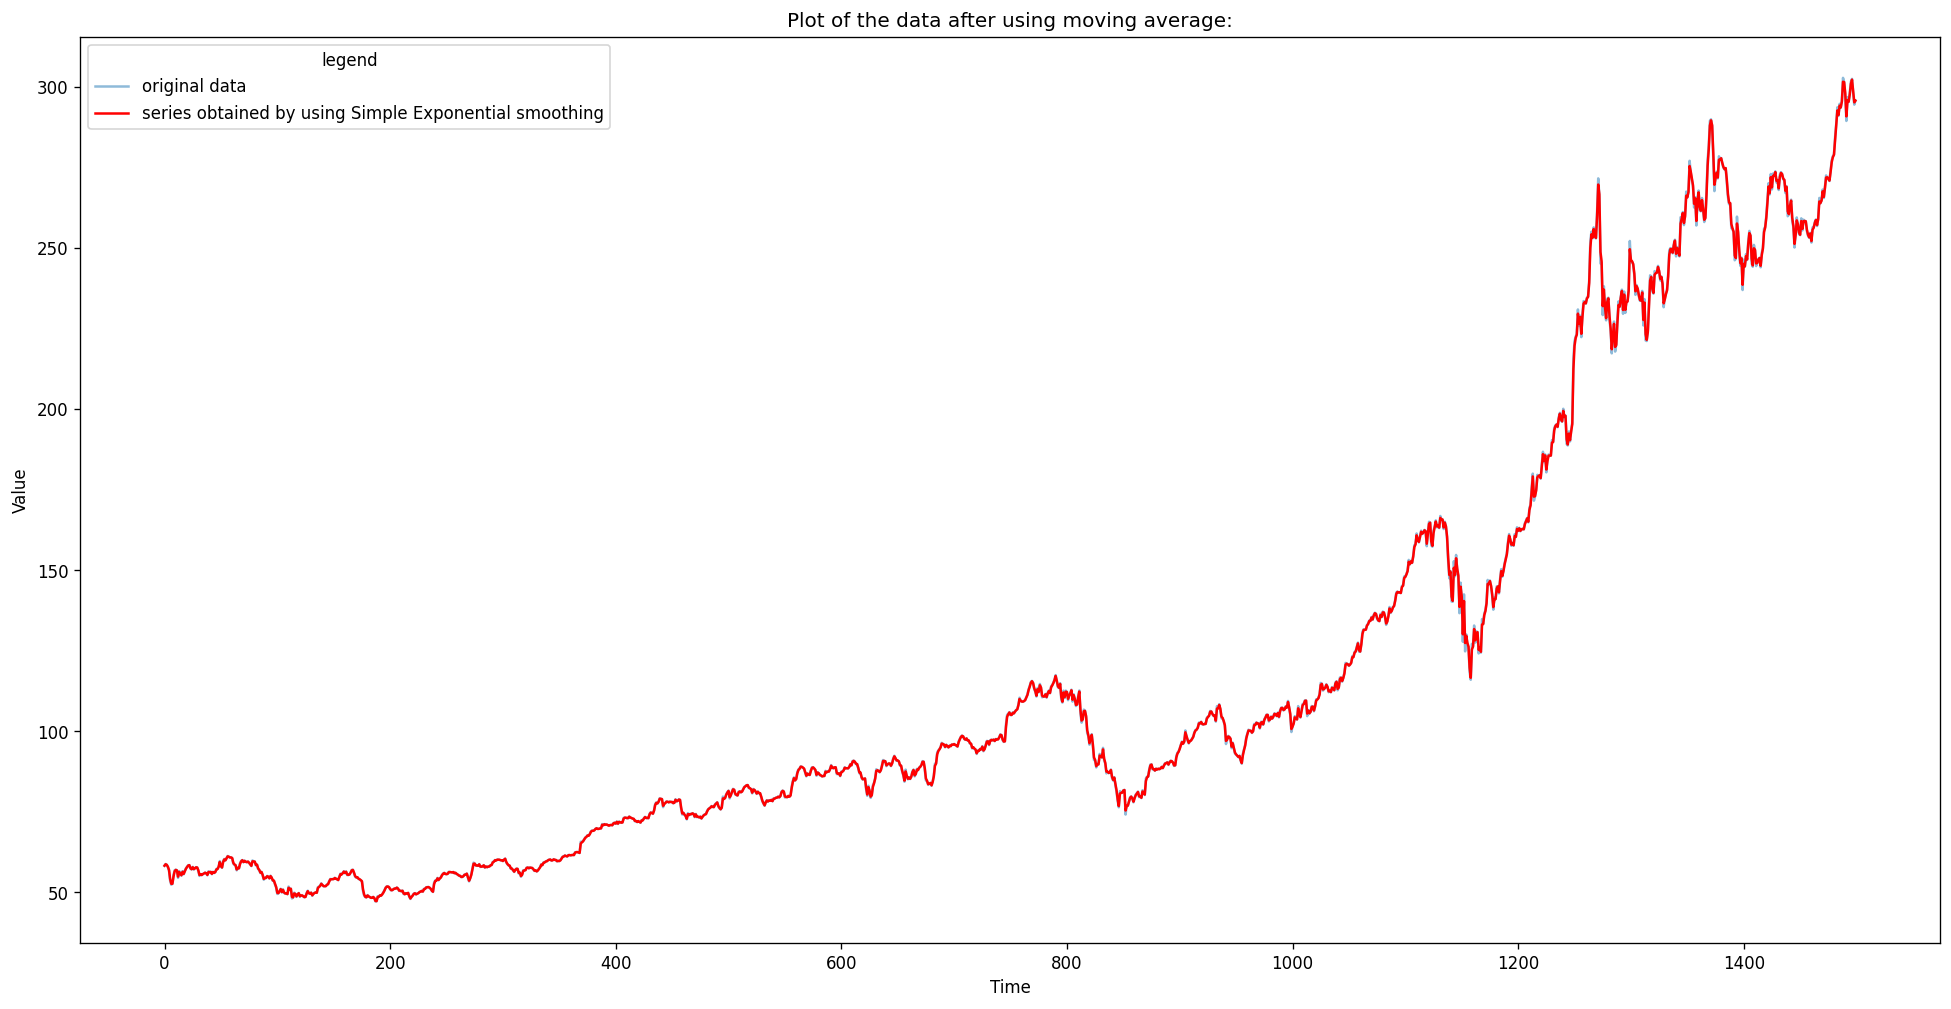

In [116]:
alpha = 0.834

# Function for Single exponential smoothing
def single_exp_smoothing(x, alpha):
    F = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        F.append(alpha * x[t] + (1 - alpha) * F[t-1])
    return F

SES = single_exp_smoothing(df[ts_col], alpha)

assert len(SES) == len(df[ts_col])


plt.figure(figsize = (20,10))
plt.plot(list(df[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot
plt.plot(SES, color = 'red')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  "series obtained by using Simple Exponential smoothing"), title = "legend")

### Double Exponential Smoothing

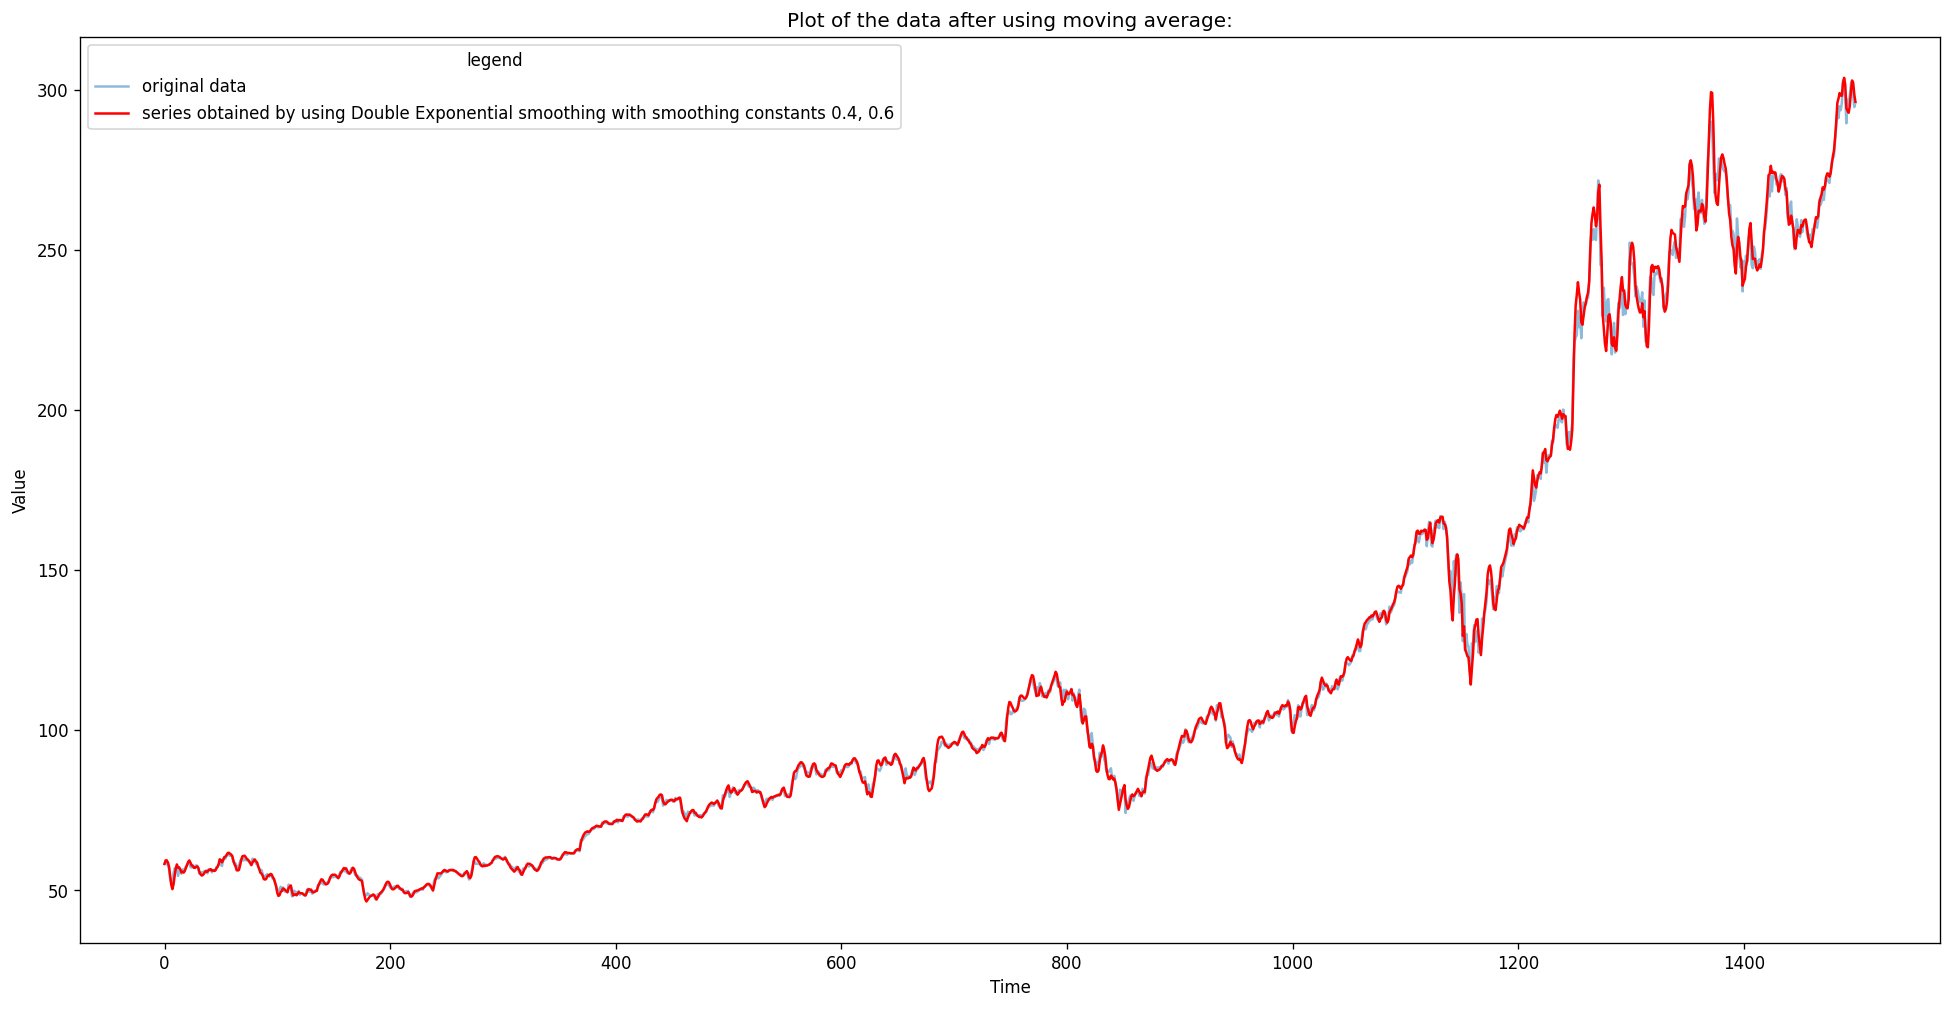

In [117]:
alpha_des, beta_des = 0.4, 0.6

def double_exp_smoothing(x, alpha, beta):
    yhat = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        if t==1:
            F, T= x[0], x[1] - x[0]
        F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
        T=beta*(F-F_n_1)+(1-beta)*T
        yhat.append(F+T)
    return yhat

    
DES = double_exp_smoothing(df[ts_col], alpha_des, beta_des)

assert len(DES) == len(df[ts_col])

plt.figure(figsize = (20,10))
plt.plot(list(df[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot
plt.plot(DES, color = 'red')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  "series obtained by using Double Exponential smoothing with smoothing constants %.1f, %.1f"%(alpha_des, beta_des)), title = "legend")

### Triple Exponential Smoothing

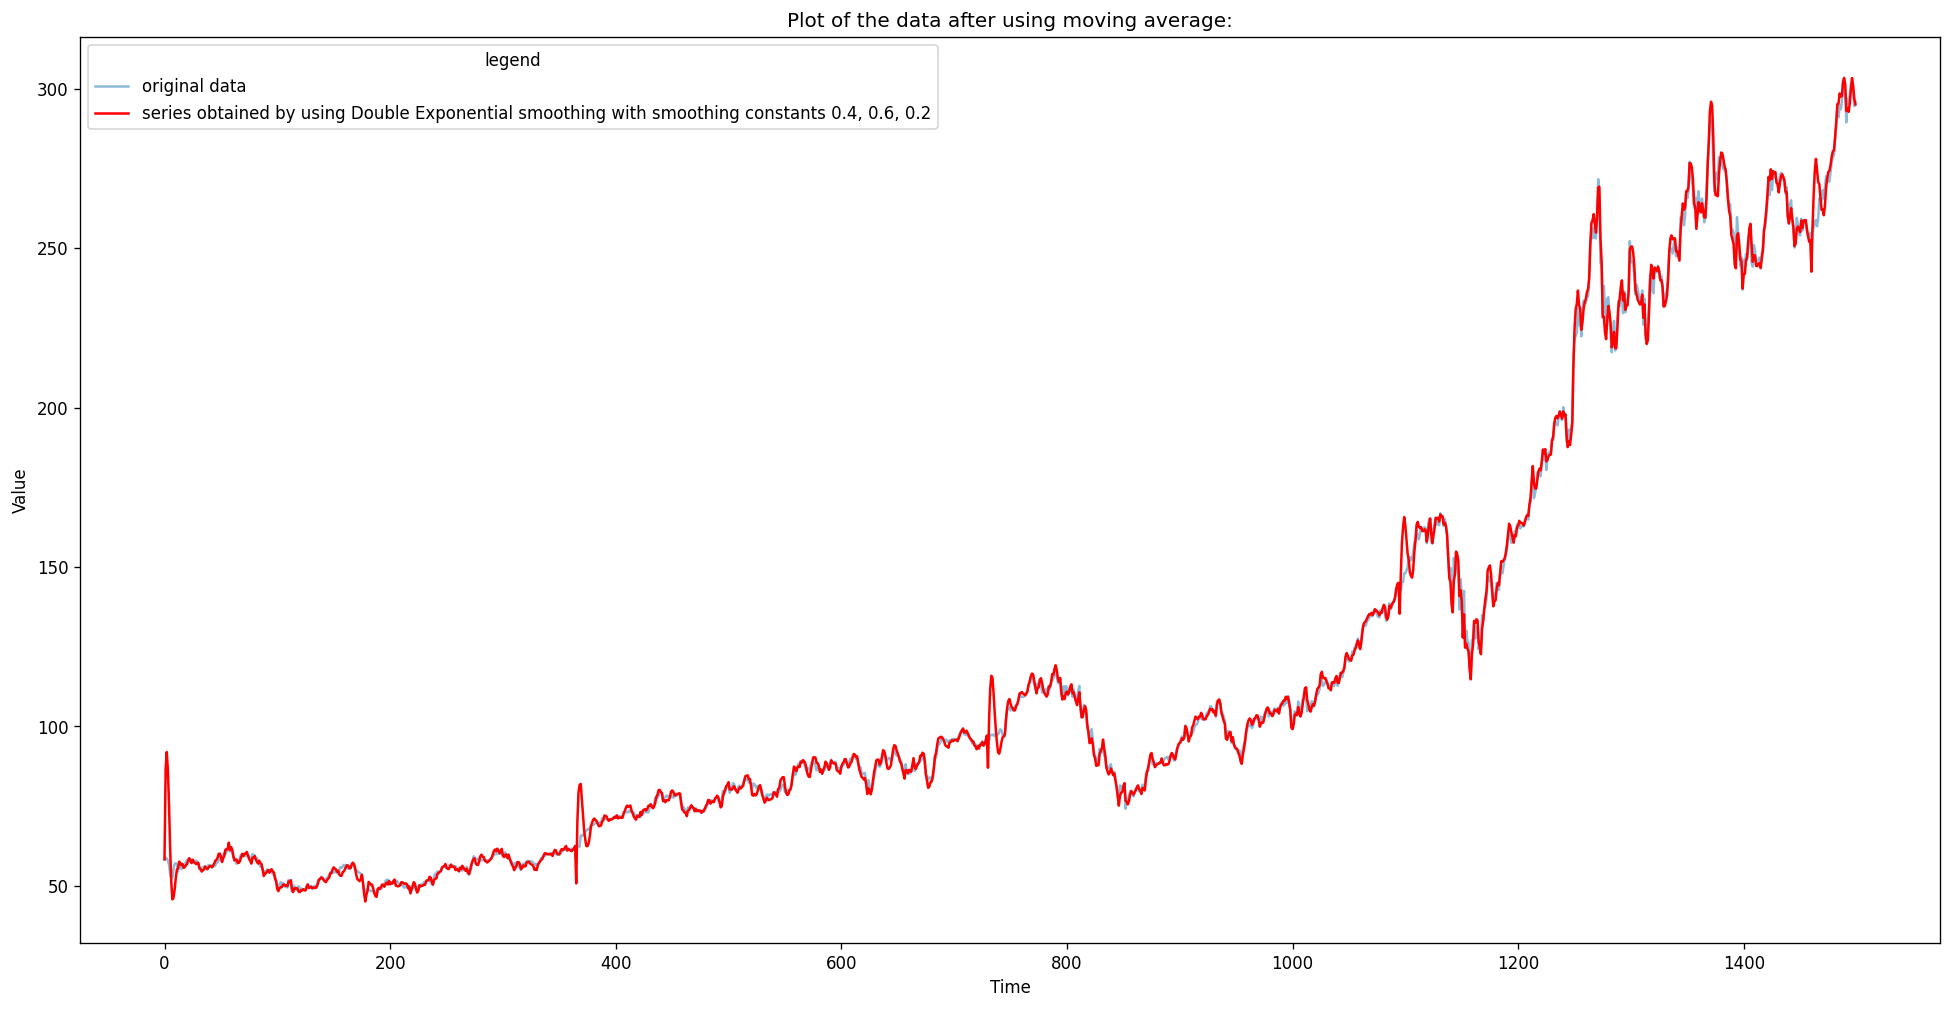

In [118]:
alpha_tes, beta_tes, gamma_tes = 0.4, 0.6, 0.2
# Capture seasonality component
def initialize_T(x, seasonLength):
    total=0.0
    for i in range(seasonLength):
        total+=float(x[i+seasonLength]-x[i])/seasonLength
    return total

initialize_T(df[ts_col], 365)

# Initialize seasonal trend
def initialize_seasonalilty(x, seasonLength):
    seasons={}
    seasonsMean=[]
    num_season=int(len(x)/seasonLength)
    # Compute season average
    for i in range(num_season):
        seasonsMean.append(sum(x[seasonLength*i:seasonLength*i+seasonLength])/float(seasonLength))
    
    # compute season intial values
    for i in range(seasonLength):
        tot=0.0
        for j in range(num_season):
            tot+=x[seasonLength*j+i]-seasonsMean[j]
        seasons[i]=tot/num_season
    return seasons
            
initialize_seasonalilty(df[ts_col], 365)   
        

# Triple Exponential Smoothing Forecast
def triple_exp_smoothing(x, seasonLength, alpha, beta, gamma):
    yhat=[]
    S = initialize_seasonalilty(x, seasonLength)
    for i in range(len(x)):
        if i == 0:
            F = x[0]
            T = initialize_T(x, seasonLength)
            yhat.append(x[0])
            continue
        if i >= len(x):
            m = i - len(x) + 1
            yhat.append((F + m*T) + S[i%seasonLength])
        else:
            obsval = x[i]
            F_last, F= F, alpha*(obsval-S[i%seasonLength]) + (1-alpha)*(F+T)
            T = beta * (F-F_last) + (1-beta)*T
            S[i%seasonLength] = gamma*(obsval-F) + (1-gamma)*S[i%seasonLength]
            yhat.append(F+T+S[i%seasonLength])
    return yhat


TES =  triple_exp_smoothing(df[ts_col], 365, alpha_tes, beta_tes, gamma_tes)

assert len(DES) == len(df[ts_col])

plt.figure(figsize = (20,10))
plt.plot(list(df[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot
plt.plot(TES, color = 'red')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  "series obtained by using Double Exponential smoothing with smoothing constants %.1f, %.1f, %.1f"%(alpha_tes, beta_tes, gamma_tes)), title = "legend")

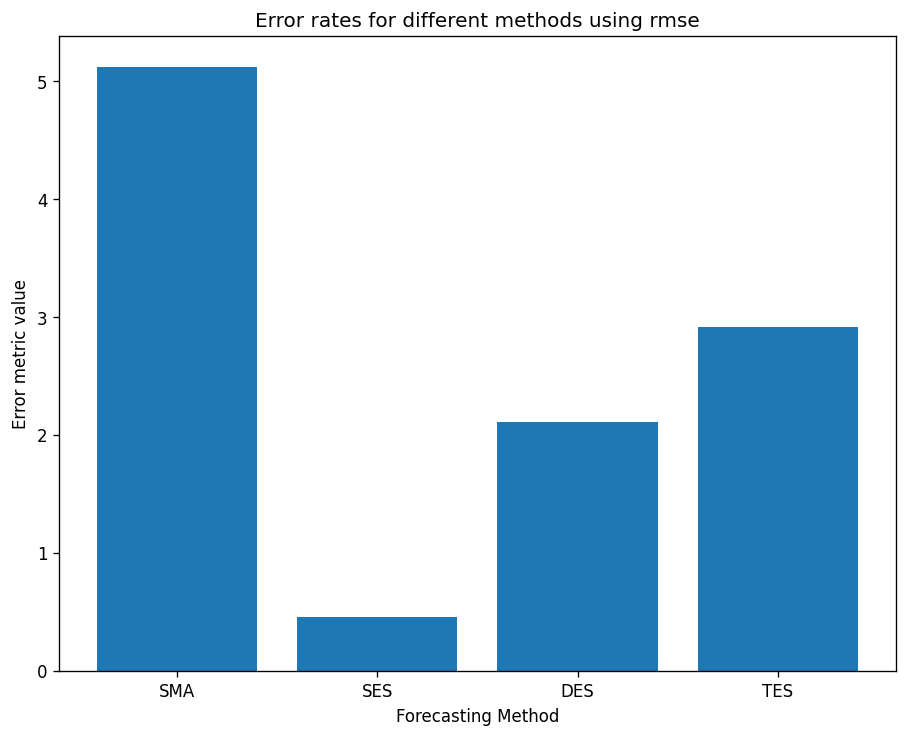

In [119]:
def mae(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.mean(np.abs(y-yhat))

def mape(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.mean(np.abs(y-yhat)/y) * 100

def mse(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.mean((y-yhat)**2)

def rmse(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.sqrt(np.mean((y-yhat)**2))

preds = [smoothed_series, SES, DES, TES]
labels = ["SMA", "SES", "DES", "TES"]
metric = rmse

y = [metric(i, df[ts_col]) for i in preds]
plt.bar(labels, y)
plt.xlabel("Forecasting Method")
plt.ylabel("Error metric value")
plt.title("Error rates for different methods using %s"%metric.__name__)
plt.show()

In [120]:
print(y)

[5.124568249274845, 0.4523134086192261, 2.109565651669464, 2.9123288063361334]


### Single Exponential Smoothing gives the least RMSE

## Comparison between Time Series Model and Regression Model:

We found that our regression model gives the best result, i.e.., least RMSE of 1.4. The best model in the time-series data gave anRMSE value of around 6.

In multi linear regression, we use all the data from the varaibles like openeing price, lowest stock price, highest stock price and volume of shares bought to predict the closing price. Hence, we think that this is a suitable model to predict future stock prices. 

In our time-series analysis, we were unable to account for the seasonality and fluctuations in the data.

### The relevant submission is present in submission.csv in the output directory.